In [ ]:
from pathlib import Path
ROOT = Path(__file__).resolve().parents[1]
DATA_DIR = ROOT / 'data'
MODEL_DIR = ROOT / 'models'
OUTPUT_DIR = ROOT / 'outputs'

In [ ]:
from ultralytics import YOLO

In [ ]:
import torch

# Verifica si CUDA (GPU) está disponible
if torch.cuda.is_available():
    print("CUDA está disponible. GPU detectada:", torch.cuda.get_device_name(0))
else:
    print("CUDA no está disponible. Se usará la CPU.")


CUDA está disponible. GPU detectada: NVIDIA GeForce RTX 4070 Ti SUPER


In [ ]:
torch.__version__

'2.5.1'

# Dataset 1,2 y 8

In [ ]:
import os
import shutil
import yaml
import cv2
import numpy as np
import random
from PIL import Image

## Configurando la copia de archivos

In [ ]:
# CONFIGURACIÓN DE RUTAS, DATASETS Y CLASES COMBINADAS

base_path = DATA_DIR / 'raw'

# Definición de cada dataset con su ruta, lista de nombres y mapeo a la lista combinada.
# Nota: En D8 se asume que "Miner" y "Rust" deben fusionarse con "miner" y "rust" de D1.
datasets = {
    "D1": {
        "path": os.path.join(base_path, "D1 - Coffee leaf diseases classification.v5i.yolov11"),
        "names": ['cerscospora', 'healthy', 'miner', 'phoma', 'rust'],
        "mapping": {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}  # idéntico a la lista combinada
    },
    "D2": {
        "path": os.path.join(base_path, "D2- Hojas de cafe enfermedades.v2i.yolov11"),
        "names": ['Falta-de-boro', 'Falta-de-calcio', 'Falta-de-fosforo', 'Falta-de-hierro', 
                  'Falta-de-magnesio', 'Falta-de-manganeso', 'Falta-de-potasio', 'Falta-nitrogeno'],
        # Se mapea para que los índices de D2 sigan a los de D1 (0 a 4)
        "mapping": {0: 5, 1: 6, 2: 7, 3: 8, 4: 9, 5: 10, 6: 11, 7: 12}
    },
    "D8": {
        "path": os.path.join(base_path, "D8 - Coffee Leaves Detection.v1i.yolov11"),
        "names": ['Miner', 'Rust'],
        # Se mapea: "Miner" se asume igual que "miner" (índice 2) y "Rust" a "rust" (índice 4)
        "mapping": {0: 2, 1: 4}
    }
}

# Lista combinada de nombres (la unión de las clases, en el orden deseado)
combined_names = ['cerscospora', 'healthy', 'miner', 'phoma', 'rust',
                  'Falta-de-boro', 'Falta-de-calcio', 'Falta-de-fosforo', 'Falta-de-hierro', 
                  'Falta-de-magnesio', 'Falta-de-manganeso', 'Falta-de-potasio', 'Falta-nitrogeno']

In [ ]:
# CREAR ESTRUCTURA DE CARPETAS COMBINADA

# Se creará una única carpeta "combinado" con subcarpetas "train", "valid" y "test"
combined_path = os.path.join(base_path, "combinado")
for split in ["train", "valid", "test"]:
    os.makedirs(os.path.join(combined_path, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(combined_path, split, "labels"), exist_ok=True)

In [ ]:
combined_path

'C:/Users/ALEX/OneDrive/Cursos/Maestría en Big Data y Data Science/Cursos-VIU/Oblgatorios/TFM/Datasets\\combinado'

In [ ]:
combined_path = os.path.normpath(combined_path)

In [ ]:
# COPIAR Y REMAPEAR LOS ARCHIVOS DE CADA DATASET

def copy_and_remap_dataset(dataset_name, dataset_info):
    """
    Copia imágenes y etiquetas del dataset original a la estructura combinada.
    Renombra los archivos para evitar conflictos y remapea los índices de clase.
    """
    src_path = dataset_info["path"]
    mapping = dataset_info["mapping"]
    
    for split in ["train", "valid", "test"]:
        src_images = os.path.join(src_path, split, "images")
        src_labels = os.path.join(src_path, split, "labels")
        dst_images = os.path.join(combined_path, split, "images")
        dst_labels = os.path.join(combined_path, split, "labels")
        
        # Copiar imágenes (se renombra con el prefijo del dataset)
        if os.path.exists(src_images):
            for fname in os.listdir(src_images):
                src_file = os.path.join(src_images, fname)
                new_fname = f"{dataset_name}_{fname}"
                dst_file = os.path.join(dst_images, new_fname)
                shutil.copy2(src_file, dst_file)
        else:
            print(f"Advertencia: No existe la carpeta {src_images}")
        
        # Copiar etiquetas y remapear índices
        if os.path.exists(src_labels):
            for fname in os.listdir(src_labels):
                src_file = os.path.join(src_labels, fname)
                new_fname = f"{dataset_name}_{fname}"
                dst_file = os.path.join(dst_labels, new_fname)
                with open(src_file, 'r') as f:
                    lines = f.readlines()
                new_lines = []
                for line in lines:
                    parts = line.strip().split()
                    if parts:
                        try:
                            cls_old = int(parts[0])
                            cls_new = mapping.get(cls_old, cls_old)
                            new_line = str(cls_new) + " " + " ".join(parts[1:]) + "\n"
                            new_lines.append(new_line)
                        except Exception as e:
                            new_lines.append(line)
                    else:
                        new_lines.append(line)
                with open(dst_file, 'w') as f:
                    f.writelines(new_lines)
        else:
            print(f"Advertencia: No existe la carpeta {src_labels}")

# Procesar cada dataset
for ds in datasets:
    print(f"Procesando dataset {ds} ...")
    copy_and_remap_dataset(ds, datasets[ds])


Procesando dataset D1 ...
Procesando dataset D2 ...
Procesando dataset D8 ...


In [ ]:
# CONTAR IMÁGENES POR CLASE EN TRAIN (CONJUNTO COMBINADO)

def count_images_per_class_combined(combined_path, combined_names):
    counts = {i: 0 for i in range(len(combined_names))}
    labels_dir = os.path.join(combined_path, "train", "labels")
    for fname in os.listdir(labels_dir):
        file_path = os.path.join(labels_dir, fname)
        try:
            with open(file_path, 'r') as f:
                lines = f.readlines()
            file_classes = set()
            for line in lines:
                parts = line.strip().split()
                if parts:
                    try:
                        cls = int(parts[0])
                        file_classes.add(cls)
                    except:
                        continue
            for cls in file_classes:
                if cls in counts:
                    counts[cls] += 1
        except Exception as e:
            print(f"Error leyendo {file_path}: {e}")
    return counts

initial_counts = count_images_per_class_combined(combined_path, combined_names)
print("Conteo inicial de imágenes por clase en TRAIN (combinado):")
for cls, count in initial_counts.items():
    print(f"  Clase {cls} ({combined_names[cls]}): {count} imágenes")

Conteo inicial de imágenes por clase en TRAIN (combinado):
  Clase 0 (cerscospora): 224 imágenes
  Clase 1 (healthy): 187 imágenes
  Clase 2 (miner): 347 imágenes
  Clase 3 (phoma): 169 imágenes
  Clase 4 (rust): 342 imágenes
  Clase 5 (Falta-de-boro): 68 imágenes
  Clase 6 (Falta-de-calcio): 112 imágenes
  Clase 7 (Falta-de-fosforo): 157 imágenes
  Clase 8 (Falta-de-hierro): 45 imágenes
  Clase 9 (Falta-de-magnesio): 52 imágenes
  Clase 10 (Falta-de-manganeso): 57 imágenes
  Clase 11 (Falta-de-potasio): 67 imágenes
  Clase 12 (Falta-nitrogeno): 45 imágenes


## Realizando el dataaumentation

In [ ]:
# DATA AUGMENTATION PARA HOMOGENIZAR LAS CLASES EN TRAIN

def find_image_file(image_dir, base_name):
    """
    Busca el archivo de imagen en image_dir que coincida con base_name
    comprobando las extensiones más comunes.
    """
    for ext in ['.jpg', '.jpeg', '.png']:
        candidate = os.path.join(image_dir, base_name + ext)
        if os.path.exists(candidate):
            return candidate
    return None

def imread_with_pil(path):
    try:
        with Image.open(path) as im:
            return np.array(im.convert("RGB"))
    except Exception as e:
        print("Error al leer con PIL:", path, e)
        return None

def augment_image_label(image_path, label_path, out_image_path, out_label_path, angle, brightness_factor):
    # Intentar leer con cv2
    img = cv2.imread(image_path)
    if img is None:
        # Si falla, intentar con PIL
        img = imread_with_pil(image_path)
        if img is None:
            print("Error al leer la imagen:", image_path)
            return
    
    h, w = img.shape[:2]
    
    # Aplicar rotación según el ángulo especificado
    if angle != 0:
        if angle == 90:
            img_aug = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        elif angle == 180:
            img_aug = cv2.rotate(img, cv2.ROTATE_180)
        elif angle == 270:
            img_aug = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        else:
            img_aug = img.copy()
    else:
        img_aug = img.copy()
    
    # Ajustar brillo
    img_aug = np.clip(img_aug * brightness_factor, 0, 255).astype(np.uint8)
    
    # Guardar imagen aumentada
    cv2.imwrite(out_image_path, img_aug)
    
    # Procesar etiqueta: ajustar las coordenadas según la rotación
    new_lines = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            if parts and len(parts) == 5:
                try:
                    cls = parts[0]
                    x = float(parts[1])
                    y = float(parts[2])
                    bw = float(parts[3])
                    bh = float(parts[4])
                    # Ajustar coordenadas para rotaciones en formato YOLO
                    if angle == 90:
                        new_x = y
                        new_y = 1 - x
                        new_bw = bh
                        new_bh = bw
                    elif angle == 180:
                        new_x = 1 - x
                        new_y = 1 - y
                        new_bw = bw
                        new_bh = bh
                    elif angle == 270:
                        new_x = 1 - y
                        new_y = x
                        new_bw = bh
                        new_bh = bw
                    else:
                        new_x, new_y, new_bw, new_bh = x, y, bw, bh
                    new_line = f"{cls} {new_x:.6f} {new_y:.6f} {new_bw:.6f} {new_bh:.6f}\n"
                    new_lines.append(new_line)
                except Exception as e:
                    new_lines.append(line)
            else:
                new_lines.append(line)
        with open(out_label_path, 'w') as f:
            f.writelines(new_lines)
    else:
        open(out_label_path, 'w').close()

# Definir el objetivo: igualar al máximo número de imágenes por clase en TRAIN
current_counts = count_images_per_class_combined(combined_path, combined_names)
target_count = max(current_counts.values())
print(f"\nObjetivo de imágenes por clase (TRAIN): {target_count}")

train_images_dir = os.path.join(combined_path, "train", "images")
train_labels_dir = os.path.join(combined_path, "train", "labels")
label_files = os.listdir(train_labels_dir)

augmented_counter = 0
augmentation_round = 0
max_rounds = 8  # para evitar ciclos infinitos

while True:
    current_counts = count_images_per_class_combined(combined_path, combined_names)
    min_count = min(current_counts.values())
    print(f"Ronda de augmentación {augmentation_round}: mínimo actual = {min_count}")
    if min_count >= target_count or augmentation_round >= max_rounds:
        break
    # Recorre cada archivo de etiqueta en TRAIN
    for fname in label_files:
        label_path = os.path.join(train_labels_dir, fname)
        # Leer clases presentes en la imagen
        with open(label_path, 'r') as f:
            lines = f.readlines()
        if not lines:
            continue
        image_classes = set()
        for line in lines:
            parts = line.strip().split()
            if parts:
                try:
                    cls = int(parts[0])
                    image_classes.add(cls)
                except:
                    continue
        # Aquí se modifica la condición:
        # Solo se aumenta si PARA TODAS las clases de la imagen el conteo actual es menor que target_count.
        underrepresented = all(current_counts[cls] < target_count for cls in image_classes)
        if underrepresented:
            # Se supone que el nombre de la etiqueta y de la imagen son iguales (sin la extensión)
            base_name = os.path.splitext(fname)[0]
            # Buscar la imagen con extensión correcta
            image_path = find_image_file(train_images_dir, base_name)
            if image_path is None:
                print("No se encontró la imagen para:", base_name)
                continue
            # Nombres para los archivos aumentados
            aug_image_name = base_name + f"_aug{augmented_counter}"
            aug_label_name = base_name + f"_aug{augmented_counter}.txt"
            # Mantener la misma extensión que la imagen encontrada
            _, ext = os.path.splitext(image_path)
            out_image_path = os.path.join(train_images_dir, aug_image_name + ext)
            out_label_path = os.path.join(train_labels_dir, aug_label_name)
            # Parámetros aleatorios de augmentación
            angle = random.choice([0, 90, 180, 270])
            brightness_factor = random.uniform(0.7, 1.3)
            augment_image_label(image_path, label_path, out_image_path, out_label_path, angle, brightness_factor)
            augmented_counter += 1
    augmentation_round += 1

final_counts = count_images_per_class_combined(combined_path, combined_names)
print("\nConteo final de imágenes por clase en TRAIN (combinado):")
for cls, count in final_counts.items():
    print(f"  Clase {cls} ({combined_names[cls]}): {count} imágenes")


Objetivo de imágenes por clase (TRAIN): 347
Ronda de augmentación 0: mínimo actual = 45
Ronda de augmentación 1: mínimo actual = 90
Ronda de augmentación 2: mínimo actual = 135
Ronda de augmentación 3: mínimo actual = 180
Ronda de augmentación 4: mínimo actual = 225
Ronda de augmentación 5: mínimo actual = 270
Ronda de augmentación 6: mínimo actual = 315
Ronda de augmentación 7: mínimo actual = 347

Conteo final de imágenes por clase en TRAIN (combinado):
  Clase 0 (cerscospora): 448 imágenes
  Clase 1 (healthy): 374 imágenes
  Clase 2 (miner): 347 imágenes
  Clase 3 (phoma): 507 imágenes
  Clase 4 (rust): 684 imágenes
  Clase 5 (Falta-de-boro): 408 imágenes
  Clase 6 (Falta-de-calcio): 448 imágenes
  Clase 7 (Falta-de-fosforo): 471 imágenes
  Clase 8 (Falta-de-hierro): 360 imágenes
  Clase 9 (Falta-de-magnesio): 364 imágenes
  Clase 10 (Falta-de-manganeso): 399 imágenes
  Clase 11 (Falta-de-potasio): 402 imágenes
  Clase 12 (Falta-nitrogeno): 360 imágenes


In [ ]:
initial_counts = count_images_per_class_combined(combined_path, combined_names)
print("Conteo final de imágenes por clase en TRAIN (combinado):")
for cls, count in initial_counts.items():
    print(f"  Clase {cls} ({combined_names[cls]}): {count} imágenes")

Conteo final de imágenes por clase en TRAIN (combinado):
  Clase 0 (cerscospora): 448 imágenes
  Clase 1 (healthy): 374 imágenes
  Clase 2 (miner): 347 imágenes
  Clase 3 (phoma): 507 imágenes
  Clase 4 (rust): 684 imágenes
  Clase 5 (Falta-de-boro): 408 imágenes
  Clase 6 (Falta-de-calcio): 448 imágenes
  Clase 7 (Falta-de-fosforo): 471 imágenes
  Clase 8 (Falta-de-hierro): 360 imágenes
  Clase 9 (Falta-de-magnesio): 364 imágenes
  Clase 10 (Falta-de-manganeso): 399 imágenes
  Clase 11 (Falta-de-potasio): 402 imágenes
  Clase 12 (Falta-nitrogeno): 360 imágenes


In [ ]:
# GENERAR data.yaml COMBINADO

data_yaml = {
    "train": os.path.join(combined_path, "train", "images").replace("\\", "/"),
    "val": os.path.join(combined_path, "valid", "images").replace("\\", "/"),
    "test": os.path.join(combined_path, "test", "images").replace("\\", "/"),
    "nc": len(combined_names),
    "names": combined_names
}
yaml_path = DATA_DIR / 'processed' / 'combinado' / 'data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, sort_keys=False)
print("\ndata.yaml combinado generado en:", yaml_path)


data.yaml combinado generado en: C:\Users\ALEX\OneDrive\Cursos\Maestría en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\Datasets\combinado\data.yaml


## Realizar entrenamiento

In [ ]:
import os
import time
import random
import numpy as np
import pandas as pd
import yaml
from ultralytics import YOLO
import onnxruntime as ort
import shutil
import subprocess
from ptflops import get_model_complexity_info

### Funciones a utilizar

In [ ]:
# Evaluación y extracción de métricas
def extract_metrics(model):
    """
    Evalúa el modelo usando model.val() y extrae las métricas de validación.
    
    Si el objeto retornado no es un diccionario, se intenta extraer atributos públicos.
    Si no se obtiene una métrica clave (por ejemplo, "metrics/precision(B)"), se intenta leer
    la última fila del CSV de resultados ubicado en 'runs/detect/train/results.csv'.
    
    Retorna:
      - metrics_dict (dict): Diccionario con las métricas.
    """
    metrics_obj = model.val()
    if isinstance(metrics_obj, dict):
        metrics_dict = metrics_obj
    else:
        try:
            metrics_dict = metrics_obj.results_dict()
        except Exception as e:
            print("No se pudo usar results_dict(), se intentará extrayendo atributos.", e)
            try:
                metrics_dict = {attr: getattr(metrics_obj, attr) 
                                for attr in dir(metrics_obj)
                                if not attr.startswith('_') and not callable(getattr(metrics_obj, attr))}
            except Exception as e:
                print("Error extrayendo atributos del objeto de validación:", e)
                metrics_dict = {}
    
    # Verificar si se obtuvo la métrica clave; de lo contrario, leer el CSV
    if not metrics_dict or "metrics/precision(B)" not in metrics_dict:
        try:
            csv_path = r"runs\detect\train\results.csv"
            if os.path.exists(csv_path):
                results_df = pd.read_csv(csv_path)
                # Se toma la última fila, que corresponde a las métricas finales
                final_metrics = results_df.iloc[-1].to_dict()
                metrics_dict = final_metrics
        except Exception as e:
            print("Error leyendo el CSV de resultados:", e)
    return metrics_dict

In [ ]:
# Exportar el modelo a ONNX y copiarlo con el nombre deseado
def export_and_copy_onnx(model, model_name, imgsz, opset=12):
    """
    Exporta el modelo a ONNX usando model.export(). Por defecto, Ultralytics guarda el ONNX
    como 'best.onnx' en 'runs/detect/train/weights'. Esta función espera a que dicho archivo exista,
    lo copia a la carpeta 'exports' con el nombre f"{model_name}.onnx" y retorna la ruta de destino.
    
    Se fuerza el parámetro opset para evitar problemas de compatibilidad (por ejemplo, Constant version 19).
    
    Parámetros:
        - model: Instancia del modelo YOLO.
        - model_name (str): Nombre identificativo del modelo.
        - imgsz (int): Tamaño de la imagen.
        - opset (int): Versión del opset para exportar (por ejemplo, 12).
    
    Retorna:
        - onnx_dest_path (str): Ruta al archivo ONNX copiado en la carpeta 'exports'.
    """
    onnx_dest_path = os.path.join("exports", f"{model_name}.onnx")
    os.makedirs("exports", exist_ok=True)
    
    # Exporta el modelo con el opset especificado
    model.export(format="onnx", imgsz=imgsz, exist_ok=True, opset=opset)
    
    default_onnx_path = MODEL_DIR / 'fine_tuned' / 'YOLO11n.onnx'
    timeout = 60
    start_time = time.time()
    # Esperar a que default_onnx_path se cree
    while not os.path.exists(default_onnx_path) and (time.time() - start_time) < timeout:
        time.sleep(1)
    if os.path.exists(default_onnx_path):
        shutil.copy2(default_onnx_path, onnx_dest_path)
    else:
        print(f"Error: No se encontró el archivo ONNX por defecto en {default_onnx_path}")
    
    # Esperar a que el archivo copiado exista en exports
    start_time = time.time()
    while not os.path.exists(onnx_dest_path) and (time.time() - start_time) < timeout:
        time.sleep(1)
    if not os.path.exists(onnx_dest_path):
        print(f"Error: No se encontró el archivo ONNX en {onnx_dest_path}")
    
    return onnx_dest_path

In [ ]:
# Exportar el modelo a TensorRT y copiarlo con el nombre deseado
def export_and_copy_trt(model, model_name, imgsz, opset=12):
    """
    Exporta el modelo a TensorRT usando model.export(format="trt"). Por defecto, 
    Ultralytics guarda el engine en 'runs/detect/train/weights' como 'best.trt'. 
    Esta función espera a que dicho archivo exista, lo copia a la carpeta 'exports' con el nombre
    f"{model_name}.trt" y retorna la ruta de destino.
    
    Se fuerza el parámetro opset para la conversión. Si tensorrt no está instalado, se captura la excepción.
    
    Parámetros:
        - model: Instancia del modelo YOLO.
        - model_name (str): Nombre identificativo del modelo.
        - imgsz (int): Tamaño de la imagen.
        - opset (int): Versión del opset para exportar.
    
    Retorna:
        - trt_dest_path (str) o None.
    """
    try:
        model.export(format="trt", imgsz=imgsz, exist_ok=True, opset=opset)
    except ModuleNotFoundError as e:
        print("TensorRT no está instalado. Se retornará None para la velocidad TRT.")
        return None
    except Exception as e:
        print("Error exportando a TensorRT:", e)
        return None

    trt_dest_path = os.path.join("exports", f"{model_name}.trt")
    os.makedirs("exports", exist_ok=True)
    
    default_trt_path = os.path.join("runs", "detect", "train", "weights", "best.trt")
    timeout = 60
    start_time = time.time()
    while not os.path.exists(default_trt_path) and (time.time() - start_time) < timeout:
        time.sleep(1)
    if os.path.exists(default_trt_path):
        shutil.copy2(default_trt_path, trt_dest_path)
    else:
        print(f"Error: No se encontró el archivo TRT por defecto en {default_trt_path}")
    
    start_time = time.time()
    while not os.path.exists(trt_dest_path) and (time.time() - start_time) < timeout:
        time.sleep(1)
    if not os.path.exists(trt_dest_path):
        print(f"Error: No se encontró el archivo TRT en {trt_dest_path}")
        return None
    return trt_dest_path

In [ ]:
# Función para exportar y copiar el checkpoint en formato PT
def export_and_copy_pt(model, model_name):
    """
    Copia el checkpoint del modelo en formato .pt. Por defecto, Ultralytics guarda el checkpoint
    como 'best.pt' en 'runs/detect/train/weights'. Esta función espera a que dicho archivo exista,
    lo copia a la carpeta 'exports' con el nombre f"{model_name}.pt" y retorna la ruta de destino.
    
    Retorna:
      - pt_dest_path (str): Ruta al archivo .pt copiado en la carpeta 'exports'.
    """
    pt_dest_path = os.path.join("exports", f"{model_name}.pt")
    os.makedirs("exports", exist_ok=True)
    
    default_pt_path = os.path.join("runs", "detect", "train", "weights", "best.pt")
    timeout = 60
    start_time = time.time()
    # Esperar a que se cree el checkpoint por defecto
    while not os.path.exists(default_pt_path) and (time.time() - start_time) < timeout:
        time.sleep(1)
    if os.path.exists(default_pt_path):
        shutil.copy2(default_pt_path, pt_dest_path)
    else:
        print(f"Error: No se encontró el archivo PT por defecto en {default_pt_path}")
    
    # Esperar a que el archivo copiado exista en exports
    start_time = time.time()
    while not os.path.exists(pt_dest_path) and (time.time() - start_time) < timeout:
        time.sleep(1)
    if not os.path.exists(pt_dest_path):
        print(f"Error: No se encontró el archivo PT en {pt_dest_path}")
    
    return pt_dest_path

In [ ]:
# Función para medir la velocidad de inferencia en CPU usando ONNX
def measure_onnx_inference_speed(onnx_path, imgsz, n_iter=20):
    """
    Mide la velocidad de inferencia en CPU usando onnxruntime.
    
    Parámetros:
      - onnx_path (str): Ruta al archivo ONNX.
      - imgsz (int): Tamaño de la imagen (ancho y alto).
      - n_iter (int): Número de iteraciones para promediar.
    
    Retorna:
      - Tiempo promedio en milisegundos.
    """
    try:
        ort_session = ort.InferenceSession(onnx_path)
        dummy_input = np.random.rand(1, 3, imgsz, imgsz).astype(np.float32)
        # Warm-up
        for _ in range(5):
            _ = ort_session.run(None, {"images": dummy_input})
        start = time.time()
        for _ in range(n_iter):
            _ = ort_session.run(None, {"images": dummy_input})
        end = time.time()
        avg_time = (end - start) / n_iter * 1000  # ms
        return avg_time
    except Exception as e:
        print(f"Error midiendo ONNX runtime: {e}")
        return None

In [ ]:
# Medir la velocidad de inferencia en T4 TensorRT usando trtexec
def measure_trt_inference_speed(trt_engine_path, n_iter=20):
    """
    Mide la velocidad de inferencia en una GPU T4 utilizando la herramienta 'trtexec'.
    Se asume que 'trtexec' está instalado y en el PATH.
    
    Parámetros:
      - trt_engine_path (str): Ruta al engine de TensorRT (archivo .trt).
      - n_iter (int): Número de iteraciones para promediar.
    
    Retorna:
      - Tiempo promedio en milisegundos (float) o None en caso de error.
    """
    if trt_engine_path is None:
        return None
    try:
        cmd = ["trtexec", f"--loadEngine={trt_engine_path}", f"--iterations={n_iter}"]
        proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
        stdout, stderr = proc.communicate(timeout=120)
        avg_time = None
        for line in stdout.splitlines():
            if "Average latency" in line:
                parts = line.split(":")
                if len(parts) > 1:
                    avg_time = float(parts[1].strip().split()[0])
                    break
        if avg_time is None:
            print("No se pudo extraer el tiempo promedio de la salida de trtexec.")
        return avg_time
    except Exception as e:
        print(f"Error midiendo TensorRT runtime: {e}")
        return None

In [ ]:
# Calular los flops
def compute_flops(model, imgsz):
    # get_model_complexity_info devuelve un string y el número total de FLOPs
    # Asegúrate de que model.model es el objeto PyTorch con el que se pueda contar FLOPs.
    macs, params = get_model_complexity_info(model.model, (3, imgsz, imgsz), as_strings=False, print_per_layer_stat=False)
    flops = 2 * macs  # MACs a FLOPs (multiplicamos por 2)
    return flops

In [ ]:
# Calcular parámetros y combinar todos los resultados
def compute_model_params(model):
    """
    Calcula la cantidad de parámetros del modelo en millones.
    
    Retorna:
      - params (float): Número de parámetros en millones.
    """
    return sum(p.numel() for p in model.model.parameters()) / 1e6

def combine_results(model_name, imgsz, metrics_dict, avg_time_cpu, avg_time_trt, params, flops):
    """
    Combina el nombre del modelo, el tamaño de la imagen, las métricas, la velocidad de inferencia,
    la cantidad de parámetros y los FLOPs en un único diccionario.
    
    Retorna:
      - results (dict): Diccionario con toda la información.
    """
    results = {
        "Modelo": model_name,
        "Tamaño (píxeles)": imgsz,
    }
    results.update(metrics_dict)
    results.update({
        "Velocidad CPU ONNX (ms)": avg_time_cpu,
        "Velocidad T4 TensorRT (ms)": avg_time_trt,
        "Parámetros (M)": params,
        "FLOPs (B)": flops
    })
    return results

### Configuraciones iniciales

In [ ]:
# Configuración de Fine Tuning y evaluación de modelos

# Lista de modelos a fine-tunear. Debes tener disponibles los pesos preentrenados.
models_info = [
    {"name": "YOLO11n", "weights": MODEL_DIR / "base" / "yolo11n.pt"},
    {"name": "YOLO12n", "weights": MODEL_DIR / "base" / "yolo12n.pt"},
    {"name": "YOLO11s", "weights": MODEL_DIR / "base" / "yolo11s.pt"},
    {"name": "YOLO12s", "weights": MODEL_DIR / "base" / "yolo12s.pt"}
]

# Parámetros de entrenamiento
epochs = 50
imgsz = 640
batch = 16
patience = 5
device = 'cuda:0'

# Ruta al archivo data.yaml del dataset combinado
yaml_path = DATA_DIR / 'processed' / 'combinado' / 'data.yaml'

results_list = []

### Entrenamiento de YOLO11n

In [ ]:
# Procesar el primer modelo: YOLO11n
info = models_info[0]
model_name = info["name"]
weights_path = info["weights"]
model = YOLO(weights_path)

# 1. Entrenamiento del modelo (fine tuning)
train_results = model.train(project=OUTPUT_DIR / "runs", 
        data=yaml_path,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        patience=patience,
        device=device,
        exist_ok=True,
        pretrained=True
        )

New https://pypi.org/project/ultralytics/8.3.84 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.82  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=C:/Users/ALEX/OneDrive/Cursos/Maestra en Big Data y Data Science/Cursos-VIU/Oblgatorios/TFM/detection-diseases-coffee/combinado/data.yaml, epochs=50, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=Fal

train: Scanning C:\Users\ALEX\OneDrive\Cursos\Maestría en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\combinado\train\labels.cache... 1876 images, 4 backgrounds, 0 corrupt: 100%|██████████| 1876/1876 [00:00<?, ?it/s]

train: WARNING  C:\Users\ALEX\OneDrive\Cursos\Maestra en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\combinado\train\images\D2_Fe-21-_jpg.rf.edc47339d1daf7530340e96080dc2f82.jpg: 1 duplicate labels removed
WARNING  Box and segment counts should be equal, but got len(segments) = 603, len(boxes) = 2472. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



val: Scanning C:\Users\ALEX\OneDrive\Cursos\Maestría en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\combinado\train\labels.cache... 1876 images, 4 backgrounds, 0 corrupt: 100%|██████████| 1876/1876 [00:00<?, ?it/s]

train: WARNING  C:\Users\ALEX\OneDrive\Cursos\Maestra en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\combinado\train\images\D2_Fe-21-_jpg.rf.edc47339d1daf7530340e96080dc2f82.jpg: 1 duplicate labels removed
WARNING  Box and segment counts should be equal, but got len(segments) = 603, len(boxes) = 2472. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.32G     0.8398      3.475      1.371         13        640: 100%|██████████| 118/118 [00:12<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  8.64it/s]


                   all       1876       2472      0.246      0.589      0.279      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.38G     0.8346      2.189      1.347         11        640: 100%|██████████| 118/118 [00:10<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.27it/s]


                   all       1876       2472      0.417      0.606      0.512      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       2.4G     0.8006      1.823      1.309         15        640: 100%|██████████| 118/118 [00:10<00:00, 11.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.47it/s]


                   all       1876       2472       0.42      0.655      0.526      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.38G     0.7638      1.627      1.273         10        640: 100%|██████████| 118/118 [00:10<00:00, 11.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.29it/s]


                   all       1876       2472      0.503      0.644      0.603      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.38G     0.7609      1.498      1.271         10        640: 100%|██████████| 118/118 [00:10<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.43it/s]


                   all       1876       2472      0.514      0.743      0.652      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.37G     0.7229      1.404      1.256         17        640: 100%|██████████| 118/118 [00:10<00:00, 11.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.27it/s]


                   all       1876       2472      0.671      0.704      0.683      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.38G     0.7207       1.32      1.238         10        640: 100%|██████████| 118/118 [00:10<00:00, 11.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.49it/s]


                   all       1876       2472       0.64      0.733      0.726      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.38G     0.7109      1.222       1.24         10        640: 100%|██████████| 118/118 [00:10<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.21it/s]

                   all       1876       2472      0.633      0.719      0.734       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.38G     0.6752       1.19      1.211         10        640: 100%|██████████| 118/118 [00:10<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.16it/s]


                   all       1876       2472      0.711      0.723      0.768      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.37G     0.6739      1.099      1.207         11        640: 100%|██████████| 118/118 [00:10<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.21it/s]


                   all       1876       2472      0.668      0.792      0.788      0.692

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.38G     0.6835      1.116      1.213         16        640: 100%|██████████| 118/118 [00:10<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.20it/s]


                   all       1876       2472      0.639       0.72      0.751      0.631

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.37G     0.6543      1.068      1.199          8        640: 100%|██████████| 118/118 [00:10<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.17it/s]


                   all       1876       2472      0.683      0.745      0.767      0.675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.38G      0.665      1.037      1.211         13        640: 100%|██████████| 118/118 [00:10<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.18it/s]

                   all       1876       2472      0.676      0.749      0.717      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.37G     0.6551     0.9921      1.189         12        640: 100%|██████████| 118/118 [00:10<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.19it/s]

                   all       1876       2472      0.668      0.793      0.812      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.37G     0.6346     0.9672      1.188         11        640: 100%|██████████| 118/118 [00:10<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.27it/s]

                   all       1876       2472      0.751      0.807      0.833      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.36G     0.6392     0.9555      1.183          9        640: 100%|██████████| 118/118 [00:10<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.19it/s]


                   all       1876       2472      0.743      0.795      0.832      0.739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.37G      0.654     0.9412      1.185         11        640: 100%|██████████| 118/118 [00:10<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.25it/s]


                   all       1876       2472      0.755       0.81      0.836      0.747

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.38G     0.6159     0.9038      1.166         14        640: 100%|██████████| 118/118 [00:10<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.22it/s]

                   all       1876       2472      0.749       0.85      0.843       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.38G     0.6093     0.8908      1.162         10        640: 100%|██████████| 118/118 [00:10<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.16it/s]

                   all       1876       2472      0.762      0.784      0.827      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.38G     0.6051     0.8733      1.157         16        640: 100%|██████████| 118/118 [00:10<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.18it/s]

                   all       1876       2472       0.77       0.83      0.853      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.37G     0.5926     0.8362      1.155         12        640: 100%|██████████| 118/118 [00:10<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.27it/s]

                   all       1876       2472       0.77      0.849      0.852      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.37G     0.6129     0.8505      1.158         19        640: 100%|██████████| 118/118 [00:10<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.23it/s]


                   all       1876       2472      0.799      0.833       0.88      0.798

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.38G     0.5966     0.8187      1.154         13        640: 100%|██████████| 118/118 [00:10<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.39it/s]


                   all       1876       2472      0.821      0.788      0.857      0.773

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.38G     0.6053     0.8117      1.154          8        640: 100%|██████████| 118/118 [00:10<00:00, 11.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.20it/s]

                   all       1876       2472      0.792      0.848      0.878      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.37G     0.6182     0.8116      1.158         14        640: 100%|██████████| 118/118 [00:10<00:00, 11.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.29it/s]

                   all       1876       2472       0.83      0.822      0.884      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.37G     0.5901     0.7897      1.143         13        640: 100%|██████████| 118/118 [00:10<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.29it/s]

                   all       1876       2472      0.819      0.861      0.886      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.38G     0.5603     0.7646      1.129         15        640: 100%|██████████| 118/118 [00:10<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.27it/s]

                   all       1876       2472        0.8      0.877      0.888      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.38G     0.5744     0.7645      1.134          9        640: 100%|██████████| 118/118 [00:10<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.32it/s]

                   all       1876       2472      0.825      0.868      0.904       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.38G     0.5638     0.7595      1.128          9        640: 100%|██████████| 118/118 [00:10<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.11it/s]

                   all       1876       2472      0.825      0.883        0.9      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.38G     0.5707     0.7223      1.135         12        640: 100%|██████████| 118/118 [00:10<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.23it/s]

                   all       1876       2472      0.847      0.856      0.898      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.38G     0.5587     0.7237      1.124          9        640: 100%|██████████| 118/118 [00:10<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.31it/s]

                   all       1876       2472      0.852      0.879      0.917      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.38G     0.5563     0.7322      1.117         12        640: 100%|██████████| 118/118 [00:10<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.28it/s]

                   all       1876       2472      0.844      0.834      0.902      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.38G     0.5487       0.69      1.117         10        640: 100%|██████████| 118/118 [00:10<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.32it/s]

                   all       1876       2472      0.849      0.883      0.917      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.37G     0.5608      0.705      1.125         10        640: 100%|██████████| 118/118 [00:10<00:00, 11.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.24it/s]

                   all       1876       2472      0.889      0.883      0.928      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.38G     0.5434     0.6745      1.117          9        640: 100%|██████████| 118/118 [00:10<00:00, 11.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.14it/s]

                   all       1876       2472      0.887      0.871      0.923      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.38G       0.55     0.6654      1.112         13        640: 100%|██████████| 118/118 [00:10<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.20it/s]

                   all       1876       2472      0.856      0.904       0.93       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.37G     0.5455     0.6821      1.113         12        640: 100%|██████████| 118/118 [00:10<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.05it/s]

                   all       1876       2472      0.867      0.912      0.941      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.38G     0.5508      0.652      1.111         10        640: 100%|██████████| 118/118 [00:10<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.31it/s]

                   all       1876       2472      0.855      0.924      0.934      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.37G      0.543     0.6443      1.111         10        640: 100%|██████████| 118/118 [00:10<00:00, 11.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.25it/s]

                   all       1876       2472      0.895      0.892      0.946      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.37G     0.5419     0.6452      1.105         12        640: 100%|██████████| 118/118 [00:10<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.29it/s]

                   all       1876       2472      0.891      0.918      0.946      0.875


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.37G     0.5698     0.5892      1.131         10        640: 100%|██████████| 118/118 [00:10<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.33it/s]

                   all       1876       2472      0.914      0.914      0.957      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.37G     0.5596      0.562      1.134          4        640: 100%|██████████| 118/118 [00:09<00:00, 11.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.27it/s]

                   all       1876       2472      0.896      0.924      0.956       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.36G     0.5507     0.5406      1.127          4        640: 100%|██████████| 118/118 [00:09<00:00, 11.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.27it/s]

                   all       1876       2472      0.894      0.924      0.955      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.36G     0.5439     0.5306      1.114          8        640: 100%|██████████| 118/118 [00:09<00:00, 11.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.26it/s]

                   all       1876       2472      0.892      0.904      0.945      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.36G     0.5427      0.517      1.108          8        640: 100%|██████████| 118/118 [00:10<00:00, 11.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.14it/s]

                   all       1876       2472      0.902      0.933       0.96      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.36G     0.5337     0.5067      1.112          5        640: 100%|██████████| 118/118 [00:09<00:00, 11.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.23it/s]

                   all       1876       2472      0.907      0.932      0.964      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.36G     0.5312     0.4947      1.102          7        640: 100%|██████████| 118/118 [00:09<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.31it/s]

                   all       1876       2472      0.905      0.939      0.964      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.36G     0.5209      0.477      1.101          8        640: 100%|██████████| 118/118 [00:09<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.34it/s]

                   all       1876       2472      0.908      0.946      0.967      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.36G     0.5165     0.4716      1.093          6        640: 100%|██████████| 118/118 [00:10<00:00, 11.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.23it/s]

                   all       1876       2472      0.923      0.937      0.969       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.36G     0.5157     0.4596      1.095          4        640: 100%|██████████| 118/118 [00:09<00:00, 11.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.37it/s]

                   all       1876       2472      0.924      0.936       0.97      0.911



50 epochs completed in 0.245 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train\weights\best.pt, 5.5MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.82  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
YOLO11n summary (fused): 100 layers, 2,584,687 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  8.26it/s]


                   all       1876       2472      0.923      0.936       0.97      0.911
           cerscospora        224        224      0.996      0.999      0.994      0.965
               healthy        187        190      0.963      0.963      0.981       0.83
                 miner        347        709       0.96      0.983       0.99      0.793
                 phoma        169        169      0.997          1      0.995      0.974
                  rust        342        577      0.892       0.79      0.932      0.629
         Falta-de-boro         68         68       0.97      0.985       0.99       0.99
       Falta-de-calcio        112        112      0.926      0.991      0.991      0.987
      Falta-de-fosforo        157        157      0.968      0.981      0.994      0.987
       Falta-de-hierro         45         45      0.855      0.933      0.958      0.938
     Falta-de-magnesio         52         52      0.761      0.904      0.915      0.915
    Falta-de-manganes

In [ ]:
# 2. Evaluación y extracción de métricas
metrics_dict = extract_metrics(model)

metrics_dict

Ultralytics 8.3.82  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
YOLO11n summary (fused): 100 layers, 2,584,687 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning C:\Users\ALEX\OneDrive\Cursos\Maestría en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\combinado\train\labels.cache... 1876 images, 4 backgrounds, 0 corrupt: 100%|██████████| 1876/1876 [00:00<?, ?it/s]

train: WARNING  C:\Users\ALEX\OneDrive\Cursos\Maestra en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\combinado\train\images\D2_Fe-21-_jpg.rf.edc47339d1daf7530340e96080dc2f82.jpg: 1 duplicate labels removed
WARNING  Box and segment counts should be equal, but got len(segments) = 603, len(boxes) = 2472. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:07<00:00, 14.84it/s]


                   all       1876       2472      0.924      0.936       0.97      0.912
           cerscospora        224        224      0.996      0.999      0.994      0.967
               healthy        187        190      0.963      0.963      0.981       0.83
                 miner        347        709      0.959      0.982       0.99      0.794
                 phoma        169        169      0.997          1      0.995      0.974
                  rust        342        577      0.896       0.79      0.932       0.63
         Falta-de-boro         68         68       0.97      0.985       0.99       0.99
       Falta-de-calcio        112        112      0.926      0.991      0.991      0.987
      Falta-de-fosforo        157        157      0.968      0.981      0.994      0.987
       Falta-de-hierro         45         45      0.855      0.933      0.958      0.938
     Falta-de-magnesio         52         52      0.763      0.904      0.916      0.914
    Falta-de-manganes

{'epoch': 50.0,
 'time': 883.183,
 'train/box_loss': 0.51573,
 'train/cls_loss': 0.45963,
 'train/dfl_loss': 1.09464,
 'metrics/precision(B)': 0.9237,
 'metrics/recall(B)': 0.93555,
 'metrics/mAP50(B)': 0.96995,
 'metrics/mAP50-95(B)': 0.91132,
 'val/box_loss': 0.48951,
 'val/cls_loss': 0.41305,
 'val/dfl_loss': 0.89411,
 'lr/pg0': 1.75224e-05,
 'lr/pg1': 1.75224e-05,
 'lr/pg2': 1.75224e-05}

In [ ]:
# Guardar ruta de exortación en formato pt
pt_export_path = export_and_copy_pt(model, model_name)

# 3. Exportar a ONNX y copiarlo con el nombre deseado
onnx_export_path = export_and_copy_onnx(model, model_name, imgsz)
avg_time_cpu = measure_onnx_inference_speed(onnx_export_path, imgsz)

# 4. Exportar a TensorRT y medir velocidad (si es posible)
trt_engine_path = export_and_copy_trt(model, model_name, imgsz)
avg_time_trt = measure_trt_inference_speed(trt_engine_path, n_iter=20)

# 5. Calcular parámetros y definir placeholder para FLOPs
params = compute_model_params(model)

flops = compute_flops(model, imgsz)

# 6. Combinar toda la información
results_yolo11n = combine_results(model_name, imgsz, metrics_dict, avg_time_cpu, avg_time_trt, params, flops)

results_list.append(results_yolo11n)

results_list

Ultralytics 8.3.82  Python-3.10.16 torch-2.5.1 CPU (AMD Ryzen 7 7700X 8-Core Processor)

PyTorch: starting from 'runs\detect\train\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 17, 8400) (5.3 MB)

ONNX: starting export with onnx 1.17.0 opset 12...
ONNX: slimming with onnxslim 0.1.48...
ONNX: export success  1.2s, saved as 'runs\detect\train\weights\best.onnx' (10.1 MB)

Export complete (1.3s)
Results saved to C:\Users\ALEX\OneDrive\Cursos\Maestra en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\runs\detect\train\weights
Predict:         yolo predict task=detect model=runs\detect\train\weights\best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs\detect\train\weights\best.onnx imgsz=640 data=C:/Users/ALEX/OneDrive/Cursos/Maestra en Big Data y Data Science/Cursos-VIU/Oblgatorios/TFM/detection-diseases-coffee/combinado/data.yaml  
Visualize:       https://netron.app
WARNING  TensorRT requires GPU export, aut

[{'Modelo': 'YOLO11n',
  'Tamaño (píxeles)': 640,
  'epoch': 50.0,
  'time': 883.183,
  'train/box_loss': 0.51573,
  'train/cls_loss': 0.45963,
  'train/dfl_loss': 1.09464,
  'metrics/precision(B)': 0.9237,
  'metrics/recall(B)': 0.93555,
  'metrics/mAP50(B)': 0.96995,
  'metrics/mAP50-95(B)': 0.91132,
  'val/box_loss': 0.48951,
  'val/cls_loss': 0.41305,
  'val/dfl_loss': 0.89411,
  'lr/pg0': 1.75224e-05,
  'lr/pg1': 1.75224e-05,
  'lr/pg2': 1.75224e-05,
  'Velocidad CPU ONNX (ms)': 22.33635187149048,
  'Velocidad T4 TensorRT (ms)': None,
  'Parámetros (M)': 2.584687,
  'FLOPs (B)': 6393562400}]

### Entrenamiento de YOLO12n

In [ ]:
# Procesar el primer modelo: YOLO12n
info = models_info[1]
model_name = info["name"]
weights_path = info["weights"]
model = YOLO(weights_path)

# 1. Entrenamiento del modelo:
train_results = model.train(project=OUTPUT_DIR / "runs", 
        data=yaml_path,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        patience=patience,
        device=device,
        exist_ok=True,
        pretrained=True)

New https://pypi.org/project/ultralytics/8.3.84 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.82  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
engine\trainer: task=detect, mode=train, model=yolo12n.pt, data=C:/Users/ALEX/OneDrive/Cursos/Maestra en Big Data y Data Science/Cursos-VIU/Oblgatorios/TFM/detection-diseases-coffee/combinado/data.yaml, epochs=50, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=Fal

train: Scanning C:\Users\ALEX\OneDrive\Cursos\Maestría en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\combinado\train\labels.cache... 1876 images, 4 backgrounds, 0 corrupt: 100%|██████████| 1876/1876 [00:00<?, ?it/s]

train: WARNING  C:\Users\ALEX\OneDrive\Cursos\Maestra en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\combinado\train\images\D2_Fe-21-_jpg.rf.edc47339d1daf7530340e96080dc2f82.jpg: 1 duplicate labels removed
WARNING  Box and segment counts should be equal, but got len(segments) = 603, len(boxes) = 2472. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



val: Scanning C:\Users\ALEX\OneDrive\Cursos\Maestría en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\combinado\train\labels.cache... 1876 images, 4 backgrounds, 0 corrupt: 100%|██████████| 1876/1876 [00:00<?, ?it/s]

train: WARNING  C:\Users\ALEX\OneDrive\Cursos\Maestra en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\combinado\train\images\D2_Fe-21-_jpg.rf.edc47339d1daf7530340e96080dc2f82.jpg: 1 duplicate labels removed
WARNING  Box and segment counts should be equal, but got len(segments) = 603, len(boxes) = 2472. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.29G     0.8255      3.341      1.368         13        640: 100%|██████████| 118/118 [00:16<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.71it/s]


                   all       1876       2472      0.521      0.398       0.36      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.42G     0.8672      2.122      1.364         11        640: 100%|██████████| 118/118 [00:14<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.61it/s]


                   all       1876       2472      0.395      0.571      0.493      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.42G      0.826      1.784      1.317         15        640: 100%|██████████| 118/118 [00:14<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.76it/s]


                   all       1876       2472      0.439      0.681      0.534      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.41G     0.7918        1.6      1.282         10        640: 100%|██████████| 118/118 [00:14<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.74it/s]


                   all       1876       2472      0.459      0.685      0.619      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       3.4G     0.7789       1.49       1.28         10        640: 100%|██████████| 118/118 [00:14<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.75it/s]

                   all       1876       2472      0.507      0.718      0.665      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       3.4G     0.7457      1.385      1.258         17        640: 100%|██████████| 118/118 [00:14<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.84it/s]

                   all       1876       2472      0.587      0.703       0.67      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.42G     0.7414      1.302      1.254         10        640: 100%|██████████| 118/118 [00:14<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.89it/s]

                   all       1876       2472      0.612      0.739      0.697      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.41G     0.7335      1.216      1.248         10        640: 100%|██████████| 118/118 [00:14<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.85it/s]

                   all       1876       2472      0.785      0.618      0.717      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.41G      0.697      1.202      1.223         10        640: 100%|██████████| 118/118 [00:14<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.93it/s]

                   all       1876       2472      0.648      0.713       0.72      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       3.4G     0.7095      1.103      1.229         11        640: 100%|██████████| 118/118 [00:14<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.93it/s]

                   all       1876       2472      0.646      0.772      0.724      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.41G     0.6933      1.099      1.219         16        640: 100%|██████████| 118/118 [00:14<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.90it/s]

                   all       1876       2472      0.638      0.761      0.735      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       3.4G     0.6667      1.065      1.206          8        640: 100%|██████████| 118/118 [00:14<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.94it/s]

                   all       1876       2472      0.658      0.779      0.748      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.41G      0.684       1.04       1.22         13        640: 100%|██████████| 118/118 [00:14<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.85it/s]

                   all       1876       2472      0.603      0.811      0.754      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       3.4G     0.6717     0.9812      1.201         12        640: 100%|██████████| 118/118 [00:14<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.85it/s]

                   all       1876       2472      0.667      0.814      0.776      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.39G     0.6465     0.9585      1.196         11        640: 100%|██████████| 118/118 [00:14<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.94it/s]

                   all       1876       2472      0.668      0.801      0.783      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.39G     0.6555     0.9502      1.192          9        640: 100%|██████████| 118/118 [00:14<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.92it/s]

                   all       1876       2472      0.624      0.825       0.77      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       3.4G     0.6675     0.9145      1.201         11        640: 100%|██████████| 118/118 [00:14<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.96it/s]

                   all       1876       2472      0.678      0.833      0.784      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       3.4G     0.6357     0.8989      1.178         14        640: 100%|██████████| 118/118 [00:14<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.89it/s]

                   all       1876       2472      0.724      0.799        0.8      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.42G     0.6264     0.8903      1.171         10        640: 100%|██████████| 118/118 [00:14<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.97it/s]

                   all       1876       2472      0.734      0.815      0.826      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.41G     0.6184     0.8593      1.173         16        640: 100%|██████████| 118/118 [00:14<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.94it/s]

                   all       1876       2472      0.707      0.794      0.787      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       3.4G     0.6072     0.8331      1.162         12        640: 100%|██████████| 118/118 [00:14<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.89it/s]

                   all       1876       2472      0.752      0.828      0.841      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.39G     0.6202     0.8393      1.169         19        640: 100%|██████████| 118/118 [00:14<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.85it/s]

                   all       1876       2472      0.769       0.82      0.822      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.41G     0.6069     0.8046      1.167         13        640: 100%|██████████| 118/118 [00:14<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  8.00it/s]

                   all       1876       2472      0.723      0.834      0.811      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.41G     0.6239     0.8049       1.17          8        640: 100%|██████████| 118/118 [00:14<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.91it/s]

                   all       1876       2472      0.741       0.84      0.842      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       3.4G     0.6441     0.7953      1.176         14        640: 100%|██████████| 118/118 [00:14<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.97it/s]

                   all       1876       2472      0.777      0.852      0.846      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.39G     0.6028     0.7872      1.155         13        640: 100%|██████████| 118/118 [00:14<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.89it/s]

                   all       1876       2472      0.766      0.859      0.858      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.41G     0.5808     0.7651      1.147         15        640: 100%|██████████| 118/118 [00:14<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.99it/s]

                   all       1876       2472      0.791       0.82       0.86      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.41G     0.5916     0.7402      1.147          9        640: 100%|██████████| 118/118 [00:14<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.80it/s]

                   all       1876       2472       0.82      0.854      0.889      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       3.4G     0.5683     0.7414      1.138          9        640: 100%|██████████| 118/118 [00:14<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.95it/s]

                   all       1876       2472      0.803      0.811      0.862      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       3.4G     0.5881     0.7224      1.147         12        640: 100%|██████████| 118/118 [00:14<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.94it/s]

                   all       1876       2472      0.811      0.847      0.879      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       3.4G     0.5656     0.7075      1.134          9        640: 100%|██████████| 118/118 [00:14<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  8.01it/s]

                   all       1876       2472      0.817      0.867      0.887      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.41G     0.5737     0.7042      1.131         12        640: 100%|██████████| 118/118 [00:13<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.95it/s]

                   all       1876       2472      0.843      0.869      0.904      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.41G     0.5642     0.6713      1.131         10        640: 100%|██████████| 118/118 [00:14<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  8.01it/s]

                   all       1876       2472      0.828       0.88      0.903      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       3.4G      0.562     0.6889      1.132         10        640: 100%|██████████| 118/118 [00:13<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  8.02it/s]

                   all       1876       2472      0.858      0.889      0.907       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.41G     0.5502      0.651      1.125          9        640: 100%|██████████| 118/118 [00:14<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  8.01it/s]

                   all       1876       2472      0.868      0.866      0.904      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.41G     0.5639     0.6576      1.126         13        640: 100%|██████████| 118/118 [00:13<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.97it/s]

                   all       1876       2472      0.877      0.872      0.917      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       3.4G      0.555     0.6523      1.128         12        640: 100%|██████████| 118/118 [00:13<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.99it/s]

                   all       1876       2472      0.831      0.876       0.91      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.41G     0.5532     0.6327      1.118         10        640: 100%|██████████| 118/118 [00:13<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  8.01it/s]

                   all       1876       2472      0.876      0.877      0.916      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.39G     0.5479     0.6205      1.121         10        640: 100%|██████████| 118/118 [00:13<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  8.06it/s]

                   all       1876       2472      0.871      0.888      0.925      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       3.4G     0.5431     0.6167      1.115         12        640: 100%|██████████| 118/118 [00:13<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  8.04it/s]

                   all       1876       2472      0.857      0.901      0.935       0.87


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       3.4G     0.5723     0.5564      1.141         10        640: 100%|██████████| 118/118 [00:14<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.93it/s]

                   all       1876       2472      0.868      0.904      0.925      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.39G     0.5634     0.5324       1.14          4        640: 100%|██████████| 118/118 [00:13<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.99it/s]

                   all       1876       2472      0.877      0.905       0.94      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.39G     0.5557      0.512      1.128          4        640: 100%|██████████| 118/118 [00:13<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  8.06it/s]

                   all       1876       2472      0.878      0.916      0.944      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.39G     0.5541     0.5017      1.124          8        640: 100%|██████████| 118/118 [00:13<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  8.03it/s]

                   all       1876       2472      0.915      0.905      0.952      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.39G     0.5439      0.486      1.119          8        640: 100%|██████████| 118/118 [00:13<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.99it/s]

                   all       1876       2472      0.911      0.908      0.948      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.39G     0.5308     0.4773      1.117          5        640: 100%|██████████| 118/118 [00:13<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  8.00it/s]

                   all       1876       2472      0.914      0.901      0.953      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.39G     0.5334     0.4719      1.108          7        640: 100%|██████████| 118/118 [00:13<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  8.03it/s]

                   all       1876       2472        0.9      0.921       0.95      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.39G     0.5207     0.4596      1.106          8        640: 100%|██████████| 118/118 [00:13<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  8.02it/s]

                   all       1876       2472       0.91      0.921      0.958        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.39G     0.5162     0.4495      1.104          6        640: 100%|██████████| 118/118 [00:13<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  8.03it/s]

                   all       1876       2472      0.908      0.953      0.965      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.39G     0.5113     0.4363      1.094          4        640: 100%|██████████| 118/118 [00:13<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.91it/s]

                   all       1876       2472      0.912      0.956      0.968      0.911



50 epochs completed in 0.313 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 5.6MB
Optimizer stripped from runs\detect\train\weights\best.pt, 5.6MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.82  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
YOLOv12n summary (fused): 159 layers, 2,559,263 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.35it/s]


                   all       1876       2472      0.912      0.956      0.968      0.911
           cerscospora        224        224      0.992          1      0.994      0.973
               healthy        187        190      0.947      0.963       0.98      0.831
                 miner        347        709      0.952      0.989      0.993      0.801
                 phoma        169        169      0.996          1      0.995      0.976
                  rust        342        577      0.877      0.862      0.937      0.634
         Falta-de-boro         68         68      0.983          1      0.994      0.994
       Falta-de-calcio        112        112       0.93      0.991      0.986      0.984
      Falta-de-fosforo        157        157      0.977      0.987      0.994      0.989
       Falta-de-hierro         45         45      0.862      0.956      0.961      0.946
     Falta-de-magnesio         52         52      0.742      0.923      0.898      0.898
    Falta-de-manganes

In [ ]:
# 2. Evaluación y extracción de métricas
metrics_dict = extract_metrics(model)

metrics_dict

Ultralytics 8.3.82  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
YOLOv12n summary (fused): 159 layers, 2,559,263 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning C:\Users\ALEX\OneDrive\Cursos\Maestría en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\combinado\train\labels.cache... 1876 images, 4 backgrounds, 0 corrupt: 100%|██████████| 1876/1876 [00:00<?, ?it/s]

train: WARNING  C:\Users\ALEX\OneDrive\Cursos\Maestra en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\combinado\train\images\D2_Fe-21-_jpg.rf.edc47339d1daf7530340e96080dc2f82.jpg: 1 duplicate labels removed
WARNING  Box and segment counts should be equal, but got len(segments) = 603, len(boxes) = 2472. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:08<00:00, 13.38it/s]


                   all       1876       2472      0.912      0.956      0.968      0.911
           cerscospora        224        224      0.992          1      0.994      0.973
               healthy        187        190      0.947      0.963       0.98      0.831
                 miner        347        709      0.952      0.989      0.993        0.8
                 phoma        169        169      0.996          1      0.995      0.976
                  rust        342        577      0.873      0.862      0.937      0.635
         Falta-de-boro         68         68      0.983          1      0.994      0.994
       Falta-de-calcio        112        112       0.93      0.991      0.986      0.984
      Falta-de-fosforo        157        157      0.977      0.987      0.994      0.989
       Falta-de-hierro         45         45      0.862      0.956      0.961      0.943
     Falta-de-magnesio         52         52      0.741      0.923      0.899      0.899
    Falta-de-manganes

{'epoch': 50.0,
 'time': 1127.04,
 'train/box_loss': 0.51129,
 'train/cls_loss': 0.43628,
 'train/dfl_loss': 1.0939,
 'metrics/precision(B)': 0.91198,
 'metrics/recall(B)': 0.95641,
 'metrics/mAP50(B)': 0.96774,
 'metrics/mAP50-95(B)': 0.91137,
 'val/box_loss': 0.47812,
 'val/cls_loss': 0.38077,
 'val/dfl_loss': 0.88336,
 'lr/pg0': 1.75224e-05,
 'lr/pg1': 1.75224e-05,
 'lr/pg2': 1.75224e-05}

In [ ]:
# Guardar ruta de exortación en formato pt
pt_export_path = export_and_copy_pt(model, model_name)

# 3. Exportar a ONNX y copiarlo con el nombre deseado
onnx_export_path = export_and_copy_onnx(model, model_name, imgsz)
avg_time_cpu = measure_onnx_inference_speed(onnx_export_path, imgsz)

# 4. Exportar a TensorRT y medir velocidad (si es posible)
trt_engine_path = export_and_copy_trt(model, model_name, imgsz)
avg_time_trt = measure_trt_inference_speed(trt_engine_path, n_iter=20)

# 5. Calcular parámetros y definir placeholder para FLOPs
params = compute_model_params(model)

flops = compute_flops(model, imgsz)

# 6. Combinar toda la información
results_yolo12n = combine_results(model_name, imgsz, metrics_dict, avg_time_cpu, avg_time_trt, params, flops)

results_list.append(results_yolo12n)

results_list

Ultralytics 8.3.82  Python-3.10.16 torch-2.5.1 CPU (AMD Ryzen 7 7700X 8-Core Processor)

PyTorch: starting from 'runs\detect\train\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 17, 8400) (5.3 MB)

ONNX: starting export with onnx 1.17.0 opset 12...
ONNX: slimming with onnxslim 0.1.48...
ONNX: export success  1.6s, saved as 'runs\detect\train\weights\best.onnx' (10.1 MB)

Export complete (1.7s)
Results saved to C:\Users\ALEX\OneDrive\Cursos\Maestra en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\runs\detect\train\weights
Predict:         yolo predict task=detect model=runs\detect\train\weights\best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs\detect\train\weights\best.onnx imgsz=640 data=C:/Users/ALEX/OneDrive/Cursos/Maestra en Big Data y Data Science/Cursos-VIU/Oblgatorios/TFM/detection-diseases-coffee/combinado/data.yaml  
Visualize:       https://netron.app
WARNING  TensorRT requires GPU export, aut

[{'Modelo': 'YOLO11n',
  'Tamaño (píxeles)': 640,
  'epoch': 50.0,
  'time': 883.183,
  'train/box_loss': 0.51573,
  'train/cls_loss': 0.45963,
  'train/dfl_loss': 1.09464,
  'metrics/precision(B)': 0.9237,
  'metrics/recall(B)': 0.93555,
  'metrics/mAP50(B)': 0.96995,
  'metrics/mAP50-95(B)': 0.91132,
  'val/box_loss': 0.48951,
  'val/cls_loss': 0.41305,
  'val/dfl_loss': 0.89411,
  'lr/pg0': 1.75224e-05,
  'lr/pg1': 1.75224e-05,
  'lr/pg2': 1.75224e-05,
  'Velocidad CPU ONNX (ms)': 22.33635187149048,
  'Velocidad T4 TensorRT (ms)': None,
  'Parámetros (M)': 2.584687,
  'FLOPs (B)': 6393562400},
 {'Modelo': 'YOLO12n',
  'Tamaño (píxeles)': 640,
  'epoch': 50.0,
  'time': 1127.04,
  'train/box_loss': 0.51129,
  'train/cls_loss': 0.43628,
  'train/dfl_loss': 1.0939,
  'metrics/precision(B)': 0.91198,
  'metrics/recall(B)': 0.95641,
  'metrics/mAP50(B)': 0.96774,
  'metrics/mAP50-95(B)': 0.91137,
  'val/box_loss': 0.47812,
  'val/cls_loss': 0.38077,
  'val/dfl_loss': 0.88336,
  'lr/pg0':

### Entrenamiento de YOLO11s

In [ ]:
# Procesar el primer modelo: YOLO11s
info = models_info[2]
model_name = info["name"]
weights_path = info["weights"]
model = YOLO(weights_path)

# 1. Entrenamiento del modelo:
train_results = model.train(project=OUTPUT_DIR / "runs", 
        data=yaml_path,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        patience=patience,
        device=device,
        exist_ok=True,
        pretrained=True)

New https://pypi.org/project/ultralytics/8.3.84 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.82  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
engine\trainer: task=detect, mode=train, model=yolo11s.pt, data=C:/Users/ALEX/OneDrive/Cursos/Maestra en Big Data y Data Science/Cursos-VIU/Oblgatorios/TFM/detection-diseases-coffee/combinado/data.yaml, epochs=50, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=Fal

train: Scanning C:\Users\ALEX\OneDrive\Cursos\Maestría en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\combinado\train\labels.cache... 1876 images, 4 backgrounds, 0 corrupt: 100%|██████████| 1876/1876 [00:00<?, ?it/s]

train: WARNING  C:\Users\ALEX\OneDrive\Cursos\Maestra en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\combinado\train\images\D2_Fe-21-_jpg.rf.edc47339d1daf7530340e96080dc2f82.jpg: 1 duplicate labels removed
WARNING  Box and segment counts should be equal, but got len(segments) = 603, len(boxes) = 2472. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



val: Scanning C:\Users\ALEX\OneDrive\Cursos\Maestría en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\combinado\train\labels.cache... 1876 images, 4 backgrounds, 0 corrupt: 100%|██████████| 1876/1876 [00:00<?, ?it/s]

train: WARNING  C:\Users\ALEX\OneDrive\Cursos\Maestra en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\combinado\train\images\D2_Fe-21-_jpg.rf.edc47339d1daf7530340e96080dc2f82.jpg: 1 duplicate labels removed
WARNING  Box and segment counts should be equal, but got len(segments) = 603, len(boxes) = 2472. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.02G     0.8155      2.975      1.365         13        640: 100%|██████████| 118/118 [00:15<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  6.69it/s]


                   all       1876       2472      0.531      0.574      0.512      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.12G      0.784      1.482      1.295         11        640: 100%|██████████| 118/118 [00:13<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.19it/s]


                   all       1876       2472       0.48      0.589      0.539      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.12G     0.7909      1.346      1.277         15        640: 100%|██████████| 118/118 [00:13<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.24it/s]

                   all       1876       2472      0.322      0.634      0.453      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.09G     0.7624      1.232      1.265         10        640: 100%|██████████| 118/118 [00:12<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.27it/s]

                   all       1876       2472      0.604      0.573      0.632       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       4.1G     0.7698        1.2      1.259         10        640: 100%|██████████| 118/118 [00:12<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.29it/s]

                   all       1876       2472      0.726      0.486      0.585      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.08G     0.7246      1.135      1.247         17        640: 100%|██████████| 118/118 [00:12<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.27it/s]

                   all       1876       2472      0.533       0.64      0.636      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.11G       0.73      1.103      1.241         10        640: 100%|██████████| 118/118 [00:12<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.32it/s]

                   all       1876       2472      0.601      0.736      0.724      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.09G     0.7266      1.024      1.241         10        640: 100%|██████████| 118/118 [00:12<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.30it/s]

                   all       1876       2472      0.619      0.761      0.723      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       4.1G     0.6886      1.027      1.214         10        640: 100%|██████████| 118/118 [00:12<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.26it/s]

                   all       1876       2472      0.608      0.774      0.756       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.08G     0.6896     0.9474      1.212         11        640: 100%|██████████| 118/118 [00:12<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.28it/s]

                   all       1876       2472      0.644      0.774      0.763      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.11G     0.6935     0.9683      1.209         16        640: 100%|██████████| 118/118 [00:12<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.32it/s]

                   all       1876       2472      0.669      0.728      0.773      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.08G     0.6622     0.9214      1.192          8        640: 100%|██████████| 118/118 [00:12<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.20it/s]

                   all       1876       2472      0.731      0.786      0.805      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.11G     0.6749     0.9292      1.209         13        640: 100%|██████████| 118/118 [00:12<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.27it/s]

                   all       1876       2472      0.691       0.83      0.813       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.08G     0.6649      0.888      1.186         12        640: 100%|██████████| 118/118 [00:12<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.35it/s]

                   all       1876       2472        0.7      0.787      0.792        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.09G     0.6407     0.8621      1.181         11        640: 100%|██████████| 118/118 [00:12<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.31it/s]

                   all       1876       2472      0.677      0.797      0.789      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.08G     0.6442     0.8773      1.181          9        640: 100%|██████████| 118/118 [00:12<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.29it/s]

                   all       1876       2472      0.707      0.758      0.826       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.09G     0.6677     0.8448      1.189         11        640: 100%|██████████| 118/118 [00:13<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.31it/s]

                   all       1876       2472      0.742        0.8      0.822      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.09G     0.6317     0.8357       1.17         14        640: 100%|██████████| 118/118 [00:12<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.30it/s]

                   all       1876       2472       0.75      0.798      0.836      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.11G     0.6235     0.8142      1.164         10        640: 100%|██████████| 118/118 [00:13<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.24it/s]

                   all       1876       2472      0.775      0.812      0.832      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.09G     0.6073     0.7828      1.154         16        640: 100%|██████████| 118/118 [00:12<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.34it/s]

                   all       1876       2472      0.726        0.8      0.833      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       4.1G     0.6068     0.7684       1.15         12        640: 100%|██████████| 118/118 [00:12<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.33it/s]

                   all       1876       2472      0.735       0.78      0.811      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.08G     0.6163     0.7836      1.156         19        640: 100%|██████████| 118/118 [00:12<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.28it/s]

                   all       1876       2472      0.778      0.829      0.871      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       4.1G     0.6114     0.7484      1.158         13        640: 100%|██████████| 118/118 [00:13<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.19it/s]

                   all       1876       2472        0.8      0.845      0.879      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.09G     0.6157     0.7438      1.155          8        640: 100%|██████████| 118/118 [00:13<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.28it/s]

                   all       1876       2472      0.831      0.837      0.883      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.09G     0.6299     0.7451      1.161         14        640: 100%|██████████| 118/118 [00:12<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.26it/s]

                   all       1876       2472      0.799      0.808      0.846      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.09G     0.5939     0.7363      1.144         13        640: 100%|██████████| 118/118 [00:12<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.21it/s]

                   all       1876       2472      0.743      0.851      0.869      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.11G     0.5686     0.7012      1.132         15        640: 100%|██████████| 118/118 [00:12<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.40it/s]

                   all       1876       2472      0.814      0.855      0.891      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.09G     0.5899      0.695       1.14          9        640: 100%|██████████| 118/118 [00:12<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.25it/s]

                   all       1876       2472      0.857      0.854       0.91      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.11G     0.5674     0.6857      1.128          9        640: 100%|██████████| 118/118 [00:12<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.33it/s]

                   all       1876       2472      0.851      0.828      0.894      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.09G     0.5772      0.679      1.134         12        640: 100%|██████████| 118/118 [00:12<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.34it/s]

                   all       1876       2472      0.826      0.871      0.897      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       4.1G     0.5554     0.6534      1.121          9        640: 100%|██████████| 118/118 [00:13<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.31it/s]

                   all       1876       2472      0.857      0.883       0.92      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.09G     0.5636     0.6722      1.116         12        640: 100%|██████████| 118/118 [00:12<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.28it/s]

                   all       1876       2472      0.838      0.881      0.915      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       4.1G     0.5563     0.6299       1.12         10        640: 100%|██████████| 118/118 [00:12<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.37it/s]

                   all       1876       2472      0.847      0.865      0.908       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.08G     0.5616     0.6488      1.124         10        640: 100%|██████████| 118/118 [00:12<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.35it/s]

                   all       1876       2472      0.892      0.862      0.925      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       4.1G     0.5493     0.6103      1.116          9        640: 100%|██████████| 118/118 [00:12<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.32it/s]

                   all       1876       2472      0.853      0.855      0.901       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.09G     0.5621     0.6167      1.114         13        640: 100%|██████████| 118/118 [00:12<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.28it/s]

                   all       1876       2472      0.879      0.865      0.921      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.09G     0.5486      0.617      1.112         12        640: 100%|██████████| 118/118 [00:12<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.39it/s]

                   all       1876       2472      0.889      0.873      0.932      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.09G     0.5503      0.588      1.106         10        640: 100%|██████████| 118/118 [00:12<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.36it/s]

                   all       1876       2472      0.894      0.879      0.928      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.09G     0.5377     0.5828      1.107         10        640: 100%|██████████| 118/118 [00:12<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.36it/s]

                   all       1876       2472      0.883      0.889      0.941      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.08G     0.5397     0.5787      1.103         12        640: 100%|██████████| 118/118 [00:12<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.31it/s]

                   all       1876       2472      0.898      0.892       0.94      0.875


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.09G     0.5678     0.5034      1.122         10        640: 100%|██████████| 118/118 [00:13<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.41it/s]

                   all       1876       2472      0.888      0.893      0.942      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.08G     0.5533     0.4885      1.122          4        640: 100%|██████████| 118/118 [00:12<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.26it/s]

                   all       1876       2472      0.875      0.898      0.943      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.09G     0.5506     0.4667      1.118          4        640: 100%|██████████| 118/118 [00:12<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.30it/s]

                   all       1876       2472       0.88      0.897      0.948      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.07G     0.5402     0.4545      1.107          8        640: 100%|██████████| 118/118 [00:12<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.25it/s]

                   all       1876       2472      0.899      0.895      0.945      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.09G     0.5435     0.4478      1.097          8        640: 100%|██████████| 118/118 [00:12<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.39it/s]

                   all       1876       2472      0.902      0.909      0.954      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.07G     0.5226     0.4321        1.1          5        640: 100%|██████████| 118/118 [00:12<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.30it/s]

                   all       1876       2472      0.907      0.918      0.957      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.09G     0.5319     0.4274      1.098          7        640: 100%|██████████| 118/118 [00:12<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.31it/s]

                   all       1876       2472      0.905      0.899      0.951      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.08G      0.515     0.4059       1.09          8        640: 100%|██████████| 118/118 [00:12<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.35it/s]

                   all       1876       2472      0.918      0.915       0.96      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.09G     0.5123     0.4039      1.084          6        640: 100%|██████████| 118/118 [00:12<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.30it/s]

                   all       1876       2472      0.924      0.917      0.963      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.07G     0.5034     0.3928      1.078          4        640: 100%|██████████| 118/118 [00:12<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.38it/s]

                   all       1876       2472      0.916       0.93      0.965      0.908



50 epochs completed in 0.307 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 19.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 19.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.82  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
YOLO11s summary (fused): 100 layers, 9,417,831 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  6.91it/s]


                   all       1876       2472      0.916       0.93      0.965      0.908
           cerscospora        224        224      0.995          1      0.994      0.978
               healthy        187        190      0.936      0.937      0.974      0.783
                 miner        347        709      0.967      0.987      0.993      0.813
                 phoma        169        169      0.997          1      0.995      0.974
                  rust        342        577      0.916       0.87      0.953      0.673
         Falta-de-boro         68         68      0.985      0.981      0.983      0.983
       Falta-de-calcio        112        112       0.94       0.98      0.987      0.983
      Falta-de-fosforo        157        157      0.967      0.987      0.994      0.988
       Falta-de-hierro         45         45      0.785      0.933      0.941      0.926
     Falta-de-magnesio         52         52      0.708      0.788      0.867      0.867
    Falta-de-manganes

In [ ]:
# 2. Evaluación y extracción de métricas
metrics_dict = extract_metrics(model)

metrics_dict

Ultralytics 8.3.82  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
YOLO11s summary (fused): 100 layers, 9,417,831 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning C:\Users\ALEX\OneDrive\Cursos\Maestría en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\combinado\train\labels.cache... 1876 images, 4 backgrounds, 0 corrupt: 100%|██████████| 1876/1876 [00:00<?, ?it/s]

train: WARNING  C:\Users\ALEX\OneDrive\Cursos\Maestra en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\combinado\train\images\D2_Fe-21-_jpg.rf.edc47339d1daf7530340e96080dc2f82.jpg: 1 duplicate labels removed
WARNING  Box and segment counts should be equal, but got len(segments) = 603, len(boxes) = 2472. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:09<00:00, 12.18it/s]


                   all       1876       2472      0.916       0.93      0.965      0.908
           cerscospora        224        224      0.995          1      0.993      0.977
               healthy        187        190      0.936      0.937      0.974      0.782
                 miner        347        709      0.967      0.987      0.993      0.813
                 phoma        169        169      0.997          1      0.995      0.975
                  rust        342        577      0.916       0.87      0.953      0.673
         Falta-de-boro         68         68      0.985      0.981      0.983      0.983
       Falta-de-calcio        112        112       0.94       0.98      0.987      0.983
      Falta-de-fosforo        157        157      0.967      0.987      0.994      0.988
       Falta-de-hierro         45         45      0.785      0.933      0.941      0.926
     Falta-de-magnesio         52         52      0.708      0.788      0.866      0.866
    Falta-de-manganes

{'epoch': 50.0,
 'time': 1103.55,
 'train/box_loss': 0.50343,
 'train/cls_loss': 0.39276,
 'train/dfl_loss': 1.07776,
 'metrics/precision(B)': 0.91603,
 'metrics/recall(B)': 0.92962,
 'metrics/mAP50(B)': 0.96505,
 'metrics/mAP50-95(B)': 0.9083,
 'val/box_loss': 0.46924,
 'val/cls_loss': 0.34404,
 'val/dfl_loss': 0.87531,
 'lr/pg0': 1.75224e-05,
 'lr/pg1': 1.75224e-05,
 'lr/pg2': 1.75224e-05}

In [ ]:
# Guardar ruta de exortación en formato pt
pt_export_path = export_and_copy_pt(model, model_name)

# 3. Exportar a ONNX y copiarlo con el nombre deseado
onnx_export_path = export_and_copy_onnx(model, model_name, imgsz)
avg_time_cpu = measure_onnx_inference_speed(onnx_export_path, imgsz)

# 4. Exportar a TensorRT y medir velocidad (si es posible)
trt_engine_path = export_and_copy_trt(model, model_name, imgsz)
avg_time_trt = measure_trt_inference_speed(trt_engine_path, n_iter=20)

# 5. Calcular parámetros y definir placeholder para FLOPs
params = compute_model_params(model)

flops = compute_flops(model, imgsz)

# 6. Combinar toda la información
results_yolo11s = combine_results(model_name, imgsz, metrics_dict, avg_time_cpu, avg_time_trt, params, flops)

results_list.append(results_yolo11s)

results_list

Ultralytics 8.3.82  Python-3.10.16 torch-2.5.1 CPU (AMD Ryzen 7 7700X 8-Core Processor)

PyTorch: starting from 'runs\detect\train\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 17, 8400) (18.3 MB)

ONNX: starting export with onnx 1.17.0 opset 12...
ONNX: slimming with onnxslim 0.1.48...
ONNX: export success  1.1s, saved as 'runs\detect\train\weights\best.onnx' (36.2 MB)

Export complete (1.3s)
Results saved to C:\Users\ALEX\OneDrive\Cursos\Maestra en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\runs\detect\train\weights
Predict:         yolo predict task=detect model=runs\detect\train\weights\best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs\detect\train\weights\best.onnx imgsz=640 data=C:/Users/ALEX/OneDrive/Cursos/Maestra en Big Data y Data Science/Cursos-VIU/Oblgatorios/TFM/detection-diseases-coffee/combinado/data.yaml  
Visualize:       https://netron.app
WARNING  TensorRT requires GPU export, au

[{'Modelo': 'YOLO11n',
  'Tamaño (píxeles)': 640,
  'epoch': 50.0,
  'time': 883.183,
  'train/box_loss': 0.51573,
  'train/cls_loss': 0.45963,
  'train/dfl_loss': 1.09464,
  'metrics/precision(B)': 0.9237,
  'metrics/recall(B)': 0.93555,
  'metrics/mAP50(B)': 0.96995,
  'metrics/mAP50-95(B)': 0.91132,
  'val/box_loss': 0.48951,
  'val/cls_loss': 0.41305,
  'val/dfl_loss': 0.89411,
  'lr/pg0': 1.75224e-05,
  'lr/pg1': 1.75224e-05,
  'lr/pg2': 1.75224e-05,
  'Velocidad CPU ONNX (ms)': 22.33635187149048,
  'Velocidad T4 TensorRT (ms)': None,
  'Parámetros (M)': 2.584687,
  'FLOPs (B)': 6393562400},
 {'Modelo': 'YOLO12n',
  'Tamaño (píxeles)': 640,
  'epoch': 50.0,
  'time': 1127.04,
  'train/box_loss': 0.51129,
  'train/cls_loss': 0.43628,
  'train/dfl_loss': 1.0939,
  'metrics/precision(B)': 0.91198,
  'metrics/recall(B)': 0.95641,
  'metrics/mAP50(B)': 0.96774,
  'metrics/mAP50-95(B)': 0.91137,
  'val/box_loss': 0.47812,
  'val/cls_loss': 0.38077,
  'val/dfl_loss': 0.88336,
  'lr/pg0':

### Entrenamiento de YOLO12s

In [ ]:
# Procesar el primer modelo: YOLO12s
info = models_info[3]
model_name = info["name"]
weights_path = info["weights"]
model = YOLO(weights_path)

# 1. Entrenamiento del modelo:
train_results = model.train(project=OUTPUT_DIR / "runs", 
        data=yaml_path,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        patience=patience,
        device=device,
        exist_ok=True,
        pretrained=True)

New https://pypi.org/project/ultralytics/8.3.84 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.82  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
engine\trainer: task=detect, mode=train, model=yolo12s.pt, data=C:/Users/ALEX/OneDrive/Cursos/Maestra en Big Data y Data Science/Cursos-VIU/Oblgatorios/TFM/detection-diseases-coffee/combinado/data.yaml, epochs=50, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=Fal

train: Scanning C:\Users\ALEX\OneDrive\Cursos\Maestría en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\combinado\train\labels.cache... 1876 images, 4 backgrounds, 0 corrupt: 100%|██████████| 1876/1876 [00:00<?, ?it/s]

train: WARNING  C:\Users\ALEX\OneDrive\Cursos\Maestra en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\combinado\train\images\D2_Fe-21-_jpg.rf.edc47339d1daf7530340e96080dc2f82.jpg: 1 duplicate labels removed
WARNING  Box and segment counts should be equal, but got len(segments) = 603, len(boxes) = 2472. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



val: Scanning C:\Users\ALEX\OneDrive\Cursos\Maestría en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\combinado\train\labels.cache... 1876 images, 4 backgrounds, 0 corrupt: 100%|██████████| 1876/1876 [00:00<?, ?it/s]

train: WARNING  C:\Users\ALEX\OneDrive\Cursos\Maestra en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\combinado\train\images\D2_Fe-21-_jpg.rf.edc47339d1daf7530340e96080dc2f82.jpg: 1 duplicate labels removed
WARNING  Box and segment counts should be equal, but got len(segments) = 603, len(boxes) = 2472. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.01G     0.8418      2.519      1.389         13        640: 100%|██████████| 118/118 [00:20<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.21it/s]


                   all       1876       2472      0.533      0.579      0.522      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.08G     0.8516      1.532      1.365         11        640: 100%|██████████| 118/118 [00:19<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.41it/s]


                   all       1876       2472      0.408      0.724      0.541      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.07G     0.8619      1.434      1.352         15        640: 100%|██████████| 118/118 [00:18<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.48it/s]

                   all       1876       2472      0.375      0.679      0.493      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.05G     0.8159      1.312      1.318         10        640: 100%|██████████| 118/118 [00:18<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.48it/s]

                   all       1876       2472      0.433      0.702      0.585      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.06G     0.8141      1.253      1.318         10        640: 100%|██████████| 118/118 [00:18<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.45it/s]

                   all       1876       2472      0.544       0.68      0.606      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.04G     0.7684      1.206      1.292         17        640: 100%|██████████| 118/118 [00:18<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.52it/s]

                   all       1876       2472      0.775      0.511      0.626      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.06G     0.7704      1.157      1.287         10        640: 100%|██████████| 118/118 [00:18<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.50it/s]

                   all       1876       2472      0.534       0.74      0.681      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.05G     0.7523      1.105       1.28         10        640: 100%|██████████| 118/118 [00:18<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.50it/s]

                   all       1876       2472       0.55      0.706      0.687      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.06G     0.7146      1.075      1.247         10        640: 100%|██████████| 118/118 [00:18<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.52it/s]

                   all       1876       2472      0.617      0.779       0.75      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.05G     0.7316      1.006      1.262         11        640: 100%|██████████| 118/118 [00:18<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.48it/s]

                   all       1876       2472      0.693      0.721       0.75      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.07G     0.7181      1.007      1.246         16        640: 100%|██████████| 118/118 [00:18<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.54it/s]

                   all       1876       2472      0.612      0.778       0.75       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.05G     0.6863      0.981      1.229          8        640: 100%|██████████| 118/118 [00:18<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.51it/s]

                   all       1876       2472      0.647      0.785      0.756      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.06G      0.693     0.9581      1.235         13        640: 100%|██████████| 118/118 [00:18<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.49it/s]

                   all       1876       2472      0.673      0.792      0.745      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.05G     0.6852      0.923       1.22         12        640: 100%|██████████| 118/118 [00:18<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  6.56it/s]

                   all       1876       2472      0.658      0.806      0.791      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.06G     0.6612     0.9068      1.214         11        640: 100%|██████████| 118/118 [00:18<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.52it/s]

                   all       1876       2472      0.661      0.785      0.746      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.04G      0.668     0.9073      1.213          9        640: 100%|██████████| 118/118 [00:18<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.54it/s]

                   all       1876       2472      0.679      0.795      0.819      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.06G      0.674     0.8507      1.217         11        640: 100%|██████████| 118/118 [00:18<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.52it/s]

                   all       1876       2472      0.726       0.83      0.825      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.06G     0.6441     0.8494      1.196         14        640: 100%|██████████| 118/118 [00:18<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.54it/s]

                   all       1876       2472      0.703        0.8      0.793      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.06G     0.6362     0.8295      1.193         10        640: 100%|██████████| 118/118 [00:18<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.56it/s]

                   all       1876       2472      0.729      0.803       0.83      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.05G     0.6248     0.8005      1.186         16        640: 100%|██████████| 118/118 [00:18<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.51it/s]

                   all       1876       2472      0.713      0.817      0.828      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.06G     0.6241     0.7935      1.188         12        640: 100%|██████████| 118/118 [00:18<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.47it/s]

                   all       1876       2472      0.794      0.814      0.853      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.05G     0.6277     0.8161      1.183         19        640: 100%|██████████| 118/118 [00:18<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.52it/s]

                   all       1876       2472      0.787      0.813      0.865      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.06G     0.6214     0.7803      1.181         13        640: 100%|██████████| 118/118 [00:18<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.51it/s]

                   all       1876       2472      0.736      0.861      0.833      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.05G     0.6274     0.7554      1.185          8        640: 100%|██████████| 118/118 [00:18<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.48it/s]

                   all       1876       2472      0.746      0.817      0.865      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.06G      0.647     0.7648      1.193         14        640: 100%|██████████| 118/118 [00:18<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.46it/s]

                   all       1876       2472      0.774      0.841      0.855      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.05G     0.6061     0.7342       1.17         13        640: 100%|██████████| 118/118 [00:18<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.52it/s]

                   all       1876       2472      0.792      0.837      0.876      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.06G     0.5878     0.7257      1.158         15        640: 100%|██████████| 118/118 [00:18<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.53it/s]

                   all       1876       2472      0.785      0.858      0.876      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.05G     0.6022     0.7044      1.167          9        640: 100%|██████████| 118/118 [00:18<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.54it/s]

                   all       1876       2472      0.831      0.852      0.896      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.07G     0.5808     0.7121      1.157          9        640: 100%|██████████| 118/118 [00:18<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.49it/s]

                   all       1876       2472      0.789      0.866       0.88      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.05G     0.5959     0.6921      1.163         12        640: 100%|██████████| 118/118 [00:18<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.53it/s]

                   all       1876       2472      0.762      0.861      0.879      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.06G     0.5751     0.6701      1.152          9        640: 100%|██████████| 118/118 [00:18<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.51it/s]

                   all       1876       2472      0.864      0.843      0.908      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.05G     0.5799     0.6826      1.145         12        640: 100%|██████████| 118/118 [00:18<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.45it/s]

                   all       1876       2472      0.846      0.861      0.906       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.06G     0.5658     0.6394      1.146         10        640: 100%|██████████| 118/118 [00:18<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.43it/s]

                   all       1876       2472      0.827      0.861        0.9      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.05G     0.5713     0.6645      1.149         10        640: 100%|██████████| 118/118 [00:18<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.52it/s]

                   all       1876       2472      0.859       0.88       0.92      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.06G     0.5569     0.6326      1.138          9        640: 100%|██████████| 118/118 [00:18<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.53it/s]

                   all       1876       2472      0.877      0.869      0.921      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.05G     0.5764     0.6305      1.146         13        640: 100%|██████████| 118/118 [00:18<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.45it/s]

                   all       1876       2472      0.839       0.88      0.914      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.06G     0.5608     0.6186       1.14         12        640: 100%|██████████| 118/118 [00:18<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.55it/s]

                   all       1876       2472      0.885      0.869      0.924      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.05G     0.5628     0.5971      1.137         10        640: 100%|██████████| 118/118 [00:18<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.50it/s]

                   all       1876       2472       0.87      0.891      0.927      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.06G      0.558     0.5937      1.137         10        640: 100%|██████████| 118/118 [00:18<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.47it/s]

                   all       1876       2472      0.883      0.871      0.932      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.05G     0.5556      0.581      1.133         12        640: 100%|██████████| 118/118 [00:18<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.51it/s]

                   all       1876       2472      0.873      0.886      0.931      0.863


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.06G     0.5804     0.5095      1.158         10        640: 100%|██████████| 118/118 [00:18<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.50it/s]

                   all       1876       2472      0.882      0.914      0.938      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.05G     0.5697     0.4928      1.159          4        640: 100%|██████████| 118/118 [00:18<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.48it/s]

                   all       1876       2472      0.902      0.893      0.948      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.05G     0.5627     0.4849      1.157          4        640: 100%|██████████| 118/118 [00:18<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.55it/s]

                   all       1876       2472      0.874      0.897      0.936      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.04G     0.5577     0.4578      1.149          8        640: 100%|██████████| 118/118 [00:18<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.50it/s]

                   all       1876       2472      0.879      0.904      0.946      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.05G      0.557     0.4455      1.142          8        640: 100%|██████████| 118/118 [00:18<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.47it/s]

                   all       1876       2472      0.901      0.903      0.941       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.04G     0.5431     0.4425      1.143          5        640: 100%|██████████| 118/118 [00:18<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.49it/s]

                   all       1876       2472      0.902      0.917      0.956      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.05G     0.5411     0.4292      1.127          7        640: 100%|██████████| 118/118 [00:18<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.45it/s]

                   all       1876       2472      0.905      0.925       0.96      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.04G     0.5265     0.4072      1.123          8        640: 100%|██████████| 118/118 [00:18<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.42it/s]

                   all       1876       2472      0.917      0.934      0.963      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.05G     0.5315     0.4059      1.129          6        640: 100%|██████████| 118/118 [00:18<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.48it/s]

                   all       1876       2472      0.939      0.917      0.966      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.04G     0.5161     0.3878      1.112          4        640: 100%|██████████| 118/118 [00:18<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.52it/s]

                   all       1876       2472      0.937      0.923      0.968       0.91



50 epochs completed in 0.401 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 19.0MB
Optimizer stripped from runs\detect\train\weights\best.pt, 19.0MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.82  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
YOLOv12s summary (fused): 159 layers, 9,235,911 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:09<00:00,  6.11it/s]


                   all       1876       2472      0.938      0.923      0.968       0.91
           cerscospora        224        224      0.996      0.991      0.994      0.976
               healthy        187        190      0.972      0.924      0.983      0.809
                 miner        347        709      0.964      0.976      0.993      0.799
                 phoma        169        169      0.997          1      0.995      0.973
                  rust        342        577      0.937      0.787      0.945      0.647
         Falta-de-boro         68         68      0.966      0.985      0.987      0.987
       Falta-de-calcio        112        112      0.947      0.964      0.984      0.979
      Falta-de-fosforo        157        157      0.994      0.981      0.994      0.989
       Falta-de-hierro         45         45      0.807      0.933      0.953      0.935
     Falta-de-magnesio         52         52       0.82      0.808      0.893      0.893
    Falta-de-manganes

In [ ]:
# 2. Evaluación y extracción de métricas
metrics_dict = extract_metrics(model)

metrics_dict

Ultralytics 8.3.82  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
YOLOv12s summary (fused): 159 layers, 9,235,911 parameters, 0 gradients, 21.2 GFLOPs


val: Scanning C:\Users\ALEX\OneDrive\Cursos\Maestría en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\combinado\train\labels.cache... 1876 images, 4 backgrounds, 0 corrupt: 100%|██████████| 1876/1876 [00:00<?, ?it/s]

train: WARNING  C:\Users\ALEX\OneDrive\Cursos\Maestra en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\combinado\train\images\D2_Fe-21-_jpg.rf.edc47339d1daf7530340e96080dc2f82.jpg: 1 duplicate labels removed
WARNING  Box and segment counts should be equal, but got len(segments) = 603, len(boxes) = 2472. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:11<00:00, 10.10it/s]


                   all       1876       2472      0.937      0.923      0.968       0.91
           cerscospora        224        224      0.996      0.991      0.994      0.976
               healthy        187        190      0.972      0.924      0.983      0.808
                 miner        347        709      0.964      0.976      0.993      0.799
                 phoma        169        169      0.997          1      0.995      0.974
                  rust        342        577      0.934      0.786      0.944      0.646
         Falta-de-boro         68         68      0.966      0.985      0.987      0.987
       Falta-de-calcio        112        112      0.946      0.964      0.984      0.979
      Falta-de-fosforo        157        157      0.994      0.981      0.994      0.989
       Falta-de-hierro         45         45      0.807      0.933      0.953      0.935
     Falta-de-magnesio         52         52      0.819      0.808      0.893      0.893
    Falta-de-manganes

{'epoch': 50.0,
 'time': 1441.98,
 'train/box_loss': 0.51612,
 'train/cls_loss': 0.38781,
 'train/dfl_loss': 1.11219,
 'metrics/precision(B)': 0.93749,
 'metrics/recall(B)': 0.92305,
 'metrics/mAP50(B)': 0.9678,
 'metrics/mAP50-95(B)': 0.9096,
 'val/box_loss': 0.4873,
 'val/cls_loss': 0.35821,
 'val/dfl_loss': 0.90756,
 'lr/pg0': 1.75224e-05,
 'lr/pg1': 1.75224e-05,
 'lr/pg2': 1.75224e-05}

In [ ]:
# Guardar ruta de exortación en formato pt
pt_export_path = export_and_copy_pt(model, model_name)

# 3. Exportar a ONNX y copiarlo con el nombre deseado
onnx_export_path = export_and_copy_onnx(model, model_name, imgsz)
avg_time_cpu = measure_onnx_inference_speed(onnx_export_path, imgsz)

# 4. Exportar a TensorRT y medir velocidad (si es posible)
trt_engine_path = export_and_copy_trt(model, model_name, imgsz)
avg_time_trt = measure_trt_inference_speed(trt_engine_path, n_iter=20)

# 5. Calcular parámetros y definir placeholder para FLOPs
params = compute_model_params(model)

flops = compute_flops(model, imgsz)

# 6. Combinar toda la información
results_yolo12s = combine_results(model_name, imgsz, metrics_dict, avg_time_cpu, avg_time_trt, params, flops)

results_list.append(results_yolo12s)

results_list

Ultralytics 8.3.82  Python-3.10.16 torch-2.5.1 CPU (AMD Ryzen 7 7700X 8-Core Processor)

PyTorch: starting from 'runs\detect\train\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 17, 8400) (18.1 MB)

ONNX: starting export with onnx 1.17.0 opset 12...
ONNX: slimming with onnxslim 0.1.48...
ONNX: export success  1.9s, saved as 'runs\detect\train\weights\best.onnx' (35.5 MB)

Export complete (2.2s)
Results saved to C:\Users\ALEX\OneDrive\Cursos\Maestra en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\runs\detect\train\weights
Predict:         yolo predict task=detect model=runs\detect\train\weights\best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs\detect\train\weights\best.onnx imgsz=640 data=C:/Users/ALEX/OneDrive/Cursos/Maestra en Big Data y Data Science/Cursos-VIU/Oblgatorios/TFM/detection-diseases-coffee/combinado/data.yaml  
Visualize:       https://netron.app
WARNING  TensorRT requires GPU export, au

[{'Modelo': 'YOLO11n',
  'Tamaño (píxeles)': 640,
  'epoch': 50.0,
  'time': 883.183,
  'train/box_loss': 0.51573,
  'train/cls_loss': 0.45963,
  'train/dfl_loss': 1.09464,
  'metrics/precision(B)': 0.9237,
  'metrics/recall(B)': 0.93555,
  'metrics/mAP50(B)': 0.96995,
  'metrics/mAP50-95(B)': 0.91132,
  'val/box_loss': 0.48951,
  'val/cls_loss': 0.41305,
  'val/dfl_loss': 0.89411,
  'lr/pg0': 1.75224e-05,
  'lr/pg1': 1.75224e-05,
  'lr/pg2': 1.75224e-05,
  'Velocidad CPU ONNX (ms)': 22.33635187149048,
  'Velocidad T4 TensorRT (ms)': None,
  'Parámetros (M)': 2.584687,
  'FLOPs (B)': 6393562400},
 {'Modelo': 'YOLO12n',
  'Tamaño (píxeles)': 640,
  'epoch': 50.0,
  'time': 1127.04,
  'train/box_loss': 0.51129,
  'train/cls_loss': 0.43628,
  'train/dfl_loss': 1.0939,
  'metrics/precision(B)': 0.91198,
  'metrics/recall(B)': 0.95641,
  'metrics/mAP50(B)': 0.96774,
  'metrics/mAP50-95(B)': 0.91137,
  'val/box_loss': 0.47812,
  'val/cls_loss': 0.38077,
  'val/dfl_loss': 0.88336,
  'lr/pg0':

### Revisión de resultados

In [ ]:
# Crear y mostrar la tabla comparativa
df = pd.DataFrame(results_list)

print("\nComparación de modelos fine-tuned:")
df


Comparación de modelos fine-tuned:


,Modelo,Tamaño (píxeles),epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),...,val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2,Velocidad CPU ONNX (ms),Velocidad T4 TensorRT (ms),Parámetros (M),FLOPs (B)
0,YOLO11n,640,50.0,883.183,0.51573,0.45963,1.09464,0.92370,0.93555,0.96995,...,0.48951,0.41305,0.89411,0.000018,0.000018,0.000018,22.336352,None,2.584687,6393562400
1,YOLO12n,640,50.0,1127.040,0.51129,0.43628,1.09390,0.91198,0.95641,0.96774,...,0.47812,0.38077,0.88336,0.000018,0.000018,0.000018,25.344527,None,2.559263,6409127200
2,YOLO11s,640,50.0,1103.550,0.50343,0.39276,1.07776,0.91603,0.92962,0.96505,...,0.46924,0.34404,0.87531,0.000018,0.000018,0.000018,52.629673,None,9.417831,21457421600
3,YOLO12s,640,50.0,1441.980,0.51612,0.38781,1.11219,0.93749,0.92305,0.96780,...,0.48730,0.35821,0.90756,0.000018,0.000018,0.000018,63.152516,None,9.235911,21383693600


In [ ]:
# Guardar la tabla en CSV
df.to_csv("comparacion_modelos.csv", index=False)

In [ ]:
def select_relevant_metrics(df,keywords):
    """
    A partir de un DataFrame con columnas de métricas (por ejemplo, provenientes del CSV de resultados)
    detecta cuáles son las métricas más relevantes para comparar modelos de detección y genera un texto
    explicativo de la elección.
    
    Se consideran relevantes las columnas que contengan las palabras clave:
      - precision
      - recall
      - mAP50-95
      - mAP50
    Adicionalmente, se sugieren opcionalmente columnas como 'epoch' y 'time' para analizar eficiencia.

    Retorna:
      - relevant_metrics: lista de nombres de columnas relevantes
      - optional_metrics: lista de columnas opcionales (como 'epoch' o 'time')
      - explanation: texto explicativo de la elección
    """
    # Palabras clave para métricas principales (sin importar mayúsculas o minúsculas)
    relevant_metrics = []
    for col in df.columns:
        for key in keywords:
            if key.lower() in col.lower():
                relevant_metrics.append(col)
                break

    # Métricas opcionales que se pueden usar para comparar eficiencia o duración
    optional_metrics = []
    for opt in ['time', 'epoch']:
        if opt in df.columns:
            optional_metrics.append(opt)
    
    explanation = "Se han seleccionado las siguientes métricas principales para comparar el desempeño de detección:\n"
    explanation += ", ".join(relevant_metrics) + ".\n\n"
    explanation += "Estas métricas se consideran relevantes porque:\n"
    explanation += "- Las métricas con el prefijo 'metrics/' (por ejemplo, " + ", ".join([m for m in relevant_metrics if 'metrics/' in m]) + ") " 
    explanation += "representan directamente la calidad de la detección (precisión, recall y mAP) en el conjunto de validación.\n"
    explanation += "- Los valores de 'mAP50' y 'mAP50-95' permiten evaluar el desempeño en diferentes umbrales de IoU, lo cual es crucial en tareas de detección.\n\n"
    explanation += "Adicionalmente, se consideran opcionales las siguientes columnas para analizar la eficiencia y convergencia:\n"
    explanation += ", ".join(optional_metrics) + ".\n"
    explanation += "Estas columnas indican el tiempo de entrenamiento y el número de epochs, lo que ayuda a comparar la velocidad de convergencia y el costo computacional, aunque no son indicadores directos de la calidad en inferencia.\n\n"
    explanation += "Por otro lado, se omiten columnas con prefijos como 'train/' (pérdidas de entrenamiento) y 'lr/' (tasa de aprendizaje) ya que, aunque son útiles para monitorizar el proceso de optimización, no reflejan directamente el desempeño final en la tarea de detección."
    
    return relevant_metrics, optional_metrics, explanation

In [ ]:
keywords = ['precision', 'recall', 'mAP50-95', 'mAP50']
relevant1, optional, text_explanation = select_relevant_metrics(df,keywords)
print(text_explanation)

Se han seleccionado las siguientes métricas principales para comparar el desempeño de detección:
metrics/precision(B), metrics/recall(B), metrics/mAP50(B), metrics/mAP50-95(B).

Estas métricas se consideran relevantes porque:
- Las métricas con el prefijo 'metrics/' (por ejemplo, metrics/precision(B), metrics/recall(B), metrics/mAP50(B), metrics/mAP50-95(B)) representan directamente la calidad de la detección (precisión, recall y mAP) en el conjunto de validación.
- Los valores de 'mAP50' y 'mAP50-95' permiten evaluar el desempeño en diferentes umbrales de IoU, lo cual es crucial en tareas de detección.

Adicionalmente, se consideran opcionales las siguientes columnas para analizar la eficiencia y convergencia:
time, epoch.
Estas columnas indican el tiempo de entrenamiento y el número de epochs, lo que ayuda a comparar la velocidad de convergencia y el costo computacional, aunque no son indicadores directos de la calidad en inferencia.

Por otro lado, se omiten columnas con prefijos co

In [ ]:
keywords = ['Velocidad CPU ONNX (ms)','Parámetros (M)','FLOPs (B)']
relevant2, optional, text_explanation = select_relevant_metrics(df,keywords)
print(text_explanation)

Se han seleccionado las siguientes métricas principales para comparar el desempeño de detección:
Velocidad CPU ONNX (ms), Parámetros (M), FLOPs (B).

Estas métricas se consideran relevantes porque:
- Las métricas con el prefijo 'metrics/' (por ejemplo, ) representan directamente la calidad de la detección (precisión, recall y mAP) en el conjunto de validación.
- Los valores de 'mAP50' y 'mAP50-95' permiten evaluar el desempeño en diferentes umbrales de IoU, lo cual es crucial en tareas de detección.

Adicionalmente, se consideran opcionales las siguientes columnas para analizar la eficiencia y convergencia:
time, epoch.
Estas columnas indican el tiempo de entrenamiento y el número de epochs, lo que ayuda a comparar la velocidad de convergencia y el costo computacional, aunque no son indicadores directos de la calidad en inferencia.

Por otro lado, se omiten columnas con prefijos como 'train/' (pérdidas de entrenamiento) y 'lr/' (tasa de aprendizaje) ya que, aunque son útiles para monit

In [ ]:
df[["Modelo","epoch"] + relevant1 + relevant2]

,Modelo,epoch,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),Velocidad CPU ONNX (ms),Parámetros (M),FLOPs (B)
0,YOLO11n,50.0,0.92370,0.93555,0.96995,0.91132,22.336352,2.584687,6393562400
1,YOLO12n,50.0,0.91198,0.95641,0.96774,0.91137,25.344527,2.559263,6409127200
2,YOLO11s,50.0,0.91603,0.92962,0.96505,0.90830,52.629673,9.417831,21457421600
3,YOLO12s,50.0,0.93749,0.92305,0.96780,0.90960,63.152516,9.235911,21383693600


In [ ]:
%matplotlib inline

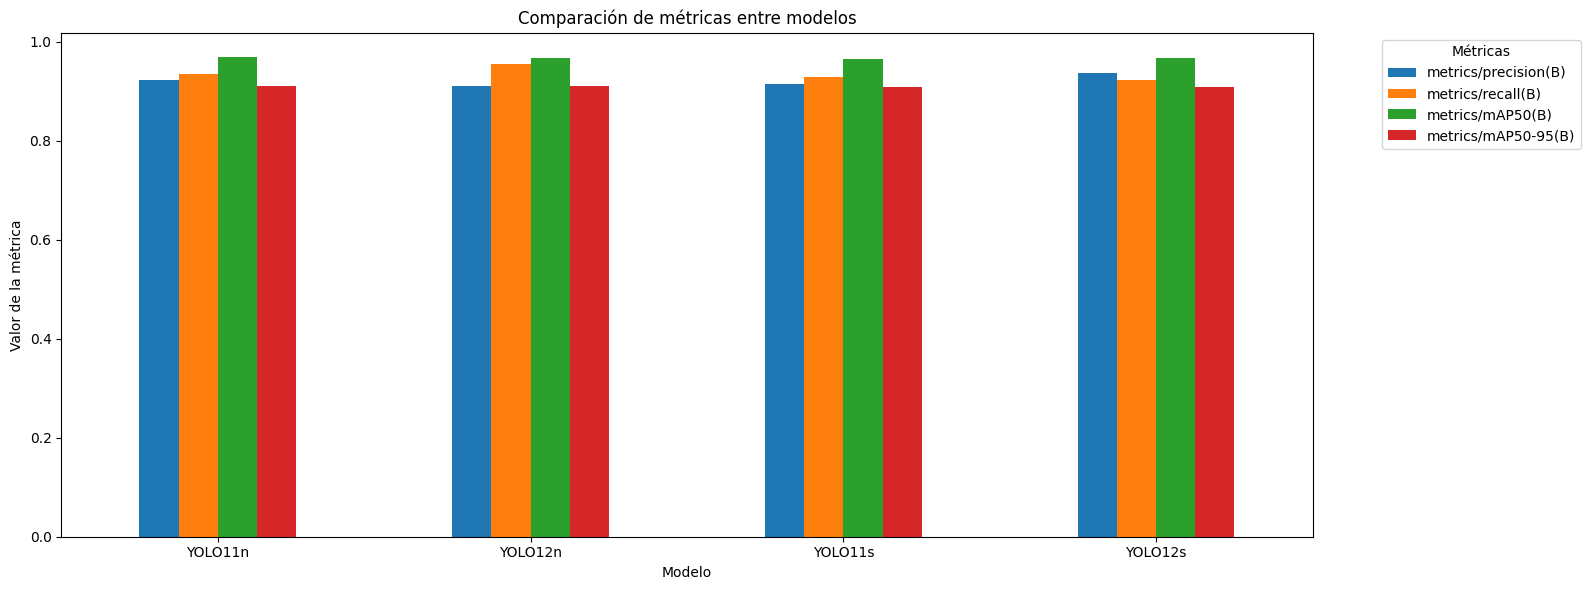

En este gráfico se comparan las siguientes métricas: metrics/precision(B), metrics/recall(B), metrics/mAP50(B), metrics/mAP50-95(B).
Cada grupo de barras corresponde a un modelo, y cada color representa una métrica distinta.

- Para la métrica 'metrics/precision(B)', el mejor modelo es **YOLO12s** con un valor de **0.9375**.
- Para la métrica 'metrics/recall(B)', el mejor modelo es **YOLO12n** con un valor de **0.9564**.
- Para la métrica 'metrics/mAP50(B)', el mejor modelo es **YOLO11n** con un valor de **0.9699**.
- Para la métrica 'metrics/mAP50-95(B)', el mejor modelo es **YOLO12n** con un valor de **0.9114**.

Resumen de cuántas veces cada modelo obtuvo el mejor valor:
  - YOLO12n: 2 métrica(s)
  - YOLO12s: 1 métrica(s)
  - YOLO11n: 1 métrica(s)

En base a estas métricas, el modelo con mayor cantidad de 'mejores resultados' se podría considerar superior. No obstante, la elección final puede depender de otras consideraciones (velocidad de inferencia, tamaño, etc.).


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_grouped_bars_and_explain(df, relevant_metrics, title="Comparación de métricas entre modelos"):
    """
    Genera un gráfico de barras agrupadas para las métricas indicadas, comparando cada modelo.
    Además, produce un texto explicativo indicando cuál modelo es mejor en cada métrica.

    Parámetros:
      - df (DataFrame): Debe contener una columna "Modelo" y columnas de métricas numéricas.
      - relevant_metrics (list): Lista de nombres de columnas de métricas a graficar.
      - title (str): Título opcional para el gráfico.

    Retorna:
      - explanation (str): Un texto que explica cuál modelo es mejor en cada métrica.
    """
    # 1. Subconjunto con "Modelo" y las métricas relevantes
    subset = df[["Modelo"] + relevant_metrics].copy()

    # 2. Establecer "Modelo" como índice para facilitar el gráfico
    subset.set_index("Modelo", inplace=True)

    # 3. Crear gráfico de barras agrupadas
    ax = subset.plot(kind="bar", figsize=(10 + 1.5*len(relevant_metrics), 6), rot=0, title=title)
    ax.set_ylabel("Valor de la métrica")
    # Mover la leyenda para que no tape el gráfico
    plt.legend(title="Métricas", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Generar explicación sobre los resultados
    explanation = f"En este gráfico se comparan las siguientes métricas: {', '.join(relevant_metrics)}.\n"
    explanation += "Cada grupo de barras corresponde a un modelo, y cada color representa una métrica distinta.\n\n"

    # 5. Determinar el/los mejor(es) modelo(s) para cada métrica
    best_models = {}
    for metric in relevant_metrics:
        # Buscar el valor máximo
        max_value = subset[metric].max()
        # Encontrar qué modelo(s) tienen ese valor máximo
        best_mods = subset[subset[metric] == max_value].index.tolist()
        best_models[metric] = (best_mods, max_value)

    # 6. Construir texto explicativo de cuál es mejor en cada métrica
    for metric, (best_mods, max_value) in best_models.items():
        if len(best_mods) == 1:
            explanation += f"- Para la métrica '{metric}', el mejor modelo es **{best_mods[0]}** con un valor de **{max_value:.4f}**.\n"
        else:
            explanation += f"- Para la métrica '{metric}', los mejores modelos son **{', '.join(best_mods)}** con un valor de **{max_value:.4f}**.\n"

    # 7. Resumen: cuántas veces cada modelo fue el mejor
    count_best = {}
    for metric, (best_mods, _) in best_models.items():
        for m in best_mods:
            count_best[m] = count_best.get(m, 0) + 1

    explanation += "\nResumen de cuántas veces cada modelo obtuvo el mejor valor:\n"
    for m, c in sorted(count_best.items(), key=lambda x: x[1], reverse=True):
        explanation += f"  - {m}: {c} métrica(s)\n"

    explanation += "\nEn base a estas métricas, el modelo con mayor cantidad de 'mejores resultados' se podría considerar superior. " \
                   "No obstante, la elección final puede depender de otras consideraciones (velocidad de inferencia, tamaño, etc.)."

    return explanation

explanation_text = plot_grouped_bars_and_explain(df, relevant1)
print(explanation_text)


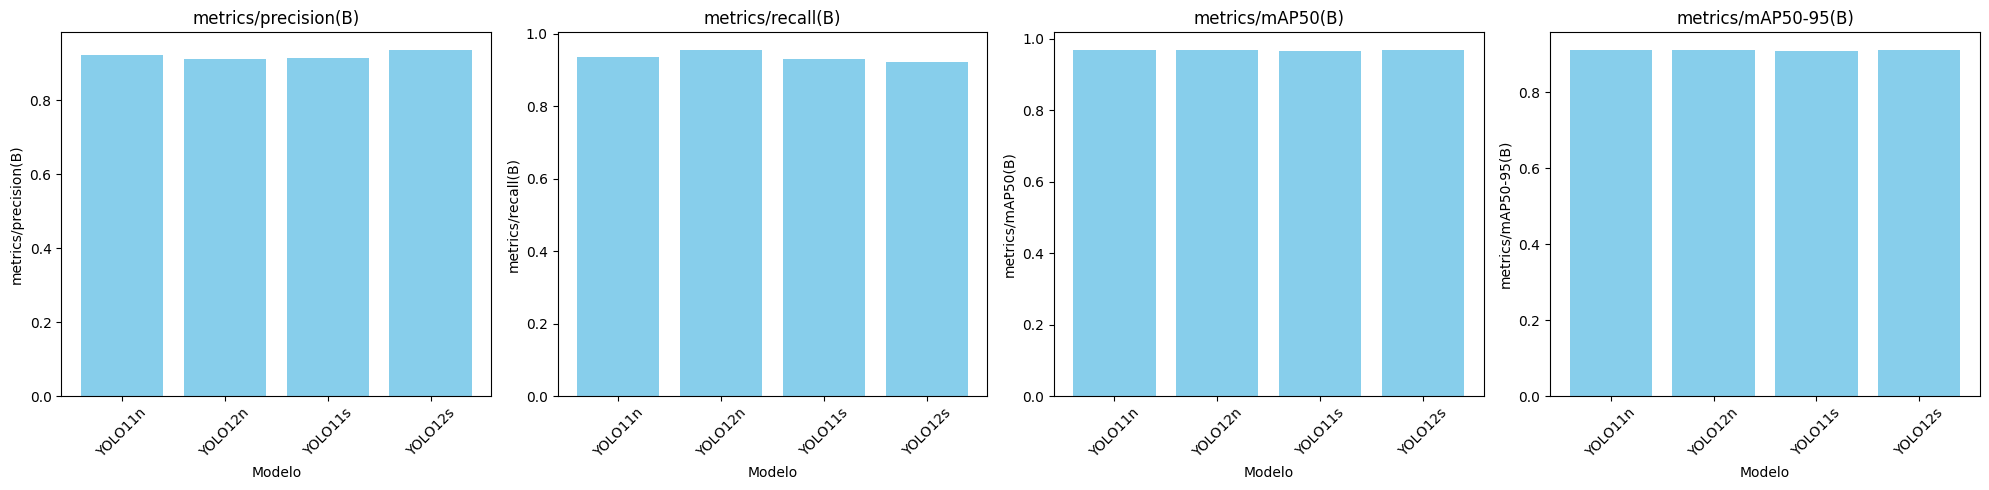

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_model_comparison(df, relevant_metrics):
    """
    Genera un gráfico de barras para cada métrica relevante comparando los modelos.
    
    Parámetros:
      - df: DataFrame que contiene los resultados por modelo.
      - relevant_metrics: Lista de columnas (métricas) a graficar.
    """
    num_metrics = len(relevant_metrics)
    # Si hay varias métricas, creamos subplots en una fila.
    fig, axes = plt.subplots(nrows=1, ncols=num_metrics, figsize=(5*num_metrics, 5))
    
    # Si sólo hay una métrica, aseguramos que axes sea una lista.
    if num_metrics == 1:
        axes = [axes]
        
    for ax, metric in zip(axes, relevant_metrics):
        # Verifica que la columna sea numérica para graficarla
        if pd.api.types.is_numeric_dtype(df[metric]):
            ax.bar(df["Modelo"], df[metric], color='skyblue')
            ax.set_title(metric)
            ax.set_xlabel("Modelo")
            ax.set_ylabel(metric)
            ax.tick_params(axis='x', rotation=45)
        else:
            ax.text(0.5, 0.5, f"No es numérica: {metric}", horizontalalignment='center', verticalalignment='center')
            ax.set_axis_off()
    plt.tight_layout()
    plt.show()

plot_model_comparison(df, relevant1)

### Análisis de resultados

1. **Métricas principales (precisión, recall, mAP50 y mAP50-95)**  
   - **YOLO11s** alcanza la mayor precisión (\(0.8074\)), así como los mejores valores de mAP50 (\(0.8679\)) y mAP50-95 (\(0.8167\)). Esto indica que, en general, YOLO11s tiene la mayor capacidad para detectar correctamente los objetos (alta precisión) y un rendimiento sólido a diferentes umbrales de IoU (mAP).  
   - **YOLO11n**, por otro lado, obtiene el mejor recall (\(0.8399\)). Esto significa que YOLO11n tiende a detectar un mayor porcentaje de objetos, aunque su precisión sea ligeramente menor.  
   - **YOLO12n** y **YOLO12s** no superan a YOLO11s ni a YOLO11n en estas métricas específicas. YOLO12n tiene un recall un poco inferior a YOLO11n y una precisión ligeramente mayor que YOLO11n, pero no alcanza los valores de YOLO11s. Por su parte, YOLO12s queda algo rezagado en todas las métricas consideradas.

2. **Tamaño del modelo (número de parámetros)**  
   - **YOLO11s** y **YOLO12s** presentan aproximadamente 9.4M y 9.2M parámetros, respectivamente, mientras que **YOLO11n** y **YOLO12n** rondan los 2.5M. Esto implica que los modelos "s" (small) son significativamente más grandes que los "n" (nano) en términos de capacidad y, potencialmente, de coste computacional.  
   - El hecho de que YOLO11s sea el modelo con mejor rendimiento coincide con que sea también uno de los más grandes, lo que sugiere que la mayor capacidad de parámetros podría estar aprovechándose para obtener un mejor ajuste a los datos.

3. **Número de épocas (epoch)**  
   - YOLO11s entrenó durante 42 épocas, mientras que YOLO12s solo 24. Esto puede indicar que YOLO12s no alcanzó su punto óptimo de entrenamiento. Del mismo modo, YOLO11n y YOLO12n entrenaron 27 y 33 épocas, respectivamente.  
   - Podría ser interesante homogeneizar el número de épocas o aplicar técnicas de early stopping consistentes para comparar los modelos en igualdad de condiciones de entrenamiento.

4. **Conclusión general**  
   - **YOLO11s** es el modelo con mejor rendimiento global en las métricas de precisión, mAP50 y mAP50-95. Sin embargo, es también el más grande en número de parámetros (junto con YOLO12s), lo que implica mayor coste computacional en entrenamiento e inferencia.  
   - **YOLO11n** destaca por su alto recall, lo que podría ser valioso en aplicaciones donde es preferible detectar tantos objetos como sea posible (aunque a costa de más falsos positivos). Además, YOLO11n es mucho más ligero que YOLO11s.  
   - **YOLO12n** y **YOLO12s** no superan los resultados de sus contrapartes "11" en las métricas analizadas, si bien YOLO12n tiene un rendimiento cercano a YOLO11n y también un número de parámetros similar.  
   - A la hora de elegir un modelo, es importante balancear la precisión, el recall y el mAP con la complejidad (número de parámetros) y la velocidad de inferencia. En este caso, si la prioridad absoluta es la calidad de detección, YOLO11s es el mejor de los cuatro; si la prioridad es un modelo ligero con alto recall, YOLO11n podría ser la mejor elección.


### Predicción

In [ ]:
import torch
from ultralytics import YOLO
import os

# Cargar el modelo YOLO
model_path = MODEL_DIR / 'fine_tuned' / 'YOLO11n.pt'
modelo_pytorch = YOLO(model_path)  # Carga la arquitectura + pesos

# Definir la carpeta de salida para predicciones
pred_dir = OUTPUT_DIR / 'predictions'
os.makedirs(pred_dir, exist_ok=True)  # Crear carpeta si no existe

# Realizar predicciones y guardarlas en la carpeta de destino
predictions = modelo_pytorch.predict(
    source=r"C:\Users\ALEX\OneDrive\Cursos\Maestría en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\imagenes de prueba",
    imgsz=640,
    save=True,         # Guarda automáticamente las imágenes con anotaciones
    project=pred_dir,  # Guarda los resultados en la carpeta personalizada
    name="predicciones"  # Nombre del subdirectorio dentro de `pred_dir`
)

print(f"Predicciones guardadas en: {pred_dir}/predicciones")


image 1/9 C:\Users\ALEX\OneDrive\Cursos\Maestra en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\imagenes de prueba\D2_Fe-29-_jpg.rf.76c26d5b72254f1d6d3da88c0bbeadb7.jpg: 640x640 3 Falta-de-hierros, 13.7ms
image 2/9 C:\Users\ALEX\OneDrive\Cursos\Maestra en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\imagenes de prueba\D2_Mn-38-_jpg.rf.55b0533d25249fcec8445f4b2c2f038f.jpg: 640x640 1 Falta-de-manganeso, 10.9ms
image 3/9 C:\Users\ALEX\OneDrive\Cursos\Maestra en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\imagenes de prueba\D2_Mn-83-_jpg.rf.33c29492e9348d75d6606324350c5325.jpg: 640x640 1 Falta-de-hierro, 10.7ms
image 4/9 C:\Users\ALEX\OneDrive\Cursos\Maestra en Big Data y Data Science\Cursos-VIU\Oblgatorios\TFM\detection-diseases-coffee\imagenes de prueba\Prueba escala alta.jpg: 448x640 1 Falta-de-boro, 4 Falta-de-calcios, 2 Falta-de-hierros, 15.9ms
image 5/9 C:\Users\ALEX\OneDrive\Cursos\Maes

: 

## Exportación en tflite

In [ ]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
import onnx
from onnx_tf.backend import prepare
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

c:\ProgramData\miniconda3\envs\export_env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


TensorFlow version: 2.12.0


In [ ]:
# Ruta para el modelo ONNX
onnx_path = MODEL_DIR / 'fine_tuned' / 'YOLO11n.onnx'

# Cargar el modelo ONNX
onnx_model = onnx.load(onnx_path)

# Preparar la representación de TensorFlow
tf_rep = prepare(onnx_model)

In [ ]:
# Obtener la información de los tensores de salida
output_tensor = onnx_model.graph.output[0]
output_shape = [dim.dim_value for dim in output_tensor.type.tensor_type.shape.dim]

# La última dimensión suele ser el número de clases
num_classes_onnx = output_shape[-1]

print(f"Cantidad de clases en el modelo ONNX: {num_classes_onnx}")

Cantidad de clases en el modelo ONNX: 8400


In [ ]:
saved_model_dir_base = "C://TEMP_MODEL_YOLO11n" #  Ruta MUY corta y simple
saved_model_dir = os.path.join(saved_model_dir_base, "OUT") # Subdirectorio también muy corto

# Asegurarse de que el directorio base exista 
os.makedirs(saved_model_dir_base, exist_ok=True) # Asegura que el directorio "Modelo" existe
# Asegurarse de que el directorio de salida del SavedModel exista
os.makedirs(saved_model_dir, exist_ok=True)

In [ ]:
# Exportar el SavedModel
tf_rep.export_graph(saved_model_dir)
print("Modelo convertido a TensorFlow SavedModel en:", saved_model_dir)

INFO:tensorflow:Assets written to: C://TEMP_MODEL_YOLO11n\OUT/assets


INFO:tensorflow:Assets written to: C://TEMP_MODEL_YOLO11n\OUT/assets


Modelo convertido a TensorFlow SavedModel en: C://TEMP_MODEL_YOLO11n\OUT


In [ ]:
import tensorflow as tf

# Cargar el modelo usando SavedModel API
model = tf.saved_model.load(r"C:\TEMP_MODEL_YOLO11n\OUT")

# Verificar las firmas del modelo
print("Firmas del modelo:", list(model.signatures.keys()))



Firmas del modelo: ['serving_default']


In [ ]:
# Obtener la salida del modelo desde la firma "serving_default"
output_shape = list(model.signatures["serving_default"].structured_outputs.values())[0].shape
num_classes = output_shape[-1]  # Última dimensión representa las clases en clasificación

print(f"Cantidad de clases en el modelo SavedModel: {num_classes}")

Cantidad de clases en el modelo SavedModel: 8400


In [ ]:
# Convertir el SavedModel a TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Guardar el modelo TFLite
tflite_path = MODEL_DIR / "fine_tuned" / "YOLO11n.tflite"
with open(tflite_path, "wb") as f:
    f.write(tflite_model)
print("Modelo exportado a TFLite y guardado en:", tflite_path)

Modelo exportado a TFLite y guardado en: Modelo\YOLO11n.tflite
